In [71]:
# jupyter notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)    #THIS LINE IS MOST IMPORTANT AS THIS WILL DISPLAY PLOT ON 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import warnings  
warnings.filterwarnings('ignore')
#https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min

# League of Legendse 關鍵 10 分鐘
##　前題介紹　ＬＯＬ
英雄聯盟是當今全球最受歡迎的 moba (multiplayer online battle arena) 遊戲，主要分常兩隊進行競技，在眾多英雄角色中選擇合適的進行戰鬥
主要會有以下重要事項:
- 以主堡為核心，先拆除對方主堡的隊伍獲得勝利
- 在拆除主堡前必須先清除 3 條主要路線中的其中一條上的所有防禦塔
- 每個玩家都會選擇自己合適的隊伍位置進行遊玩
- 除了 3 條路線外，地圖上也會有野怪能夠提供玩家一些增幅效益
- 選擇的英雄角色可以獲得經驗升級以及賺取金錢購買裝備來壓制敵人
- 每個角色都會有自己獨特的技能以及召喚師技能能夠使用

這邊選用牌位在鑽石的前 10 分鐘遊戲數據，通常在高段位的玩家能夠將極小的差距擴大並協助隊伍獲得勝利
簡單來說就是 遊戲的前 10 分鐘所發生的事大多數就能奠定這場遊戲的輸贏


In [3]:
# 確認一下數據
df = pd.read_csv('data/high_diamond_ranked_10min.csv')
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [8]:
df.shape

(9879, 40)

In [11]:
df.describe()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


In [13]:
# 檢查缺失值 將大於0的特徵列出
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

Series([], dtype: int64)

In [87]:
df['blueWins'] = df['blueWins'].map({1: 'Blue Side', 0:'Red Side'}) 
df['blueWins']

0        Red Side
1        Red Side
2        Red Side
3        Red Side
4        Red Side
          ...    
9874    Blue Side
9875    Blue Side
9876     Red Side
9877     Red Side
9878    Blue Side
Name: blueWins, Length: 9879, dtype: object

In [17]:
print(df.blueGoldDiff)
print(df.redGoldDiff)

0        643
1      -2908
2      -1172
3      -1321
4      -1004
        ... 
9874    2519
9875     782
9876   -2416
9877    -839
9878     927
Name: blueGoldDiff, Length: 9879, dtype: int64
0       -643
1       2908
2       1172
3       1321
4       1004
        ... 
9874   -2519
9875    -782
9876    2416
9877     839
9878    -927
Name: redGoldDiff, Length: 9879, dtype: int64


可以發現有些資料是成對出現，數值方面只有差負號而已

接下會將金錢差距，經驗差距轉換為二元特徵，之前有說到金錢跟經驗是獲勝的重要關鍵特徵，這邊先進行轉換處理，後續便可以直接使用


In [5]:
isneg = []
for i in df.blueGoldDiff :
    if i < 0 :
        isneg.append(0)
    else :
        isneg.append(1)
df['blueGoldDiffSituation'] = isneg
isneg = []
for i in df.redGoldDiff :
    if i < 0 :
        isneg.append(0)
    else :
        isneg.append(1)
df['redGoldDiffSituation'] = isneg

isneg = []
for i in df.blueExperienceDiff :
    if i < 0 :
        isneg.append(0)
    else :
        isneg.append(1)
df['blueExperienceDiffSituation'] = isneg
isneg = []
for i in df.redExperienceDiff :
    if i < 0 :
        isneg.append(0)
    else :
        isneg.append(1)
df['redExperienceDiffSituation'] = isneg
# 相等的狀況下雙邊都是1

In [6]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   object 
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

None

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueGoldDiffSituation,redGoldDiffSituation,blueExperienceDiffSituation,redExperienceDiffSituation
0,4519157822,Red Side,28,2,1,9,6,11,0,0,...,197,55,-643,8,19.7,1656.7,1,0,0,1
1,4523371949,Red Side,12,1,0,5,5,5,0,0,...,240,52,2908,1173,24.0,1762.0,0,1,0,1
2,4521474530,Red Side,15,0,0,7,11,4,1,1,...,203,28,1172,1033,20.3,1728.5,0,1,0,1
3,4524384067,Red Side,43,1,0,4,5,5,1,0,...,235,47,1321,7,23.5,1647.8,0,1,0,1
4,4436033771,Red Side,75,4,0,6,6,6,0,0,...,225,67,1004,-230,22.5,1740.4,0,1,1,0


## 比較紅藍方數據
兩隊隊伍會因起始重生點的位置分別劃分為紅方以及藍方
接下來會分別比較兩方的數據

### - 眼的數量

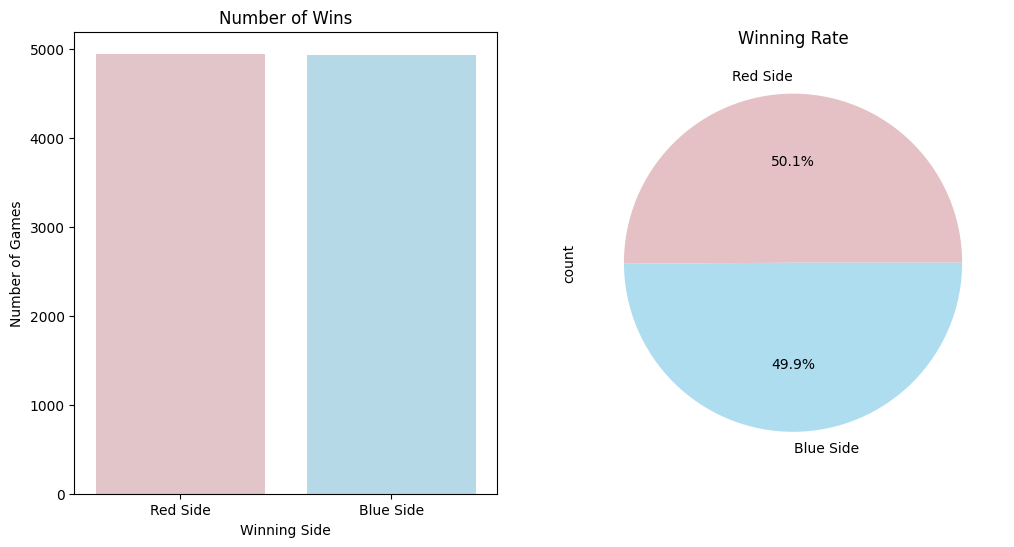

blueWins
Red Side     4949
Blue Side    4930
Name: count, dtype: int64


In [46]:
# 確認 dataset 中紅藍方勝利的次數
shade = ["#E5C1C5", "#AEDDEF"] # red side 用紅色 blue side 用藍色
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df, x='blueWins', ax=ax[0], palette=shade)
ax[0].set_title('Number of Wins')
ax[0].set_xlabel('Winning Side')
ax[0].set_ylabel('Number of Games')
df['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], colors=shade)
ax[1].set_title('Winning Rate')
plt.show()
print(df['blueWins'].value_counts())


由此可以看出勝場數蠻平均，不存在哪方天生就較有優勢

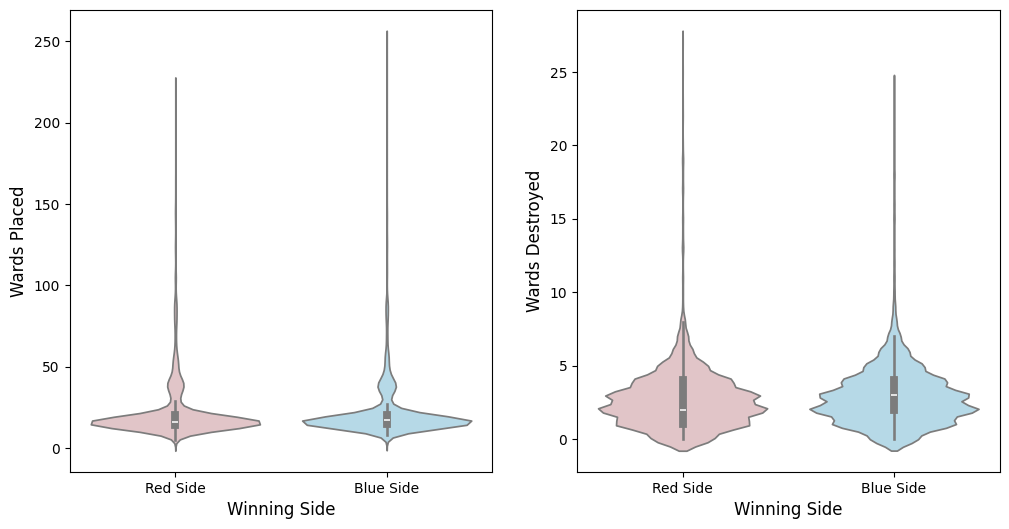

In [51]:
# 看插眼的資料與紅藍方勝利的分布。小提琴圖(violinplot) 比起盒鬚圖(boxplot)更能強調資料密集在哪
shade = ["#E5C1C5", "#AEDDEF"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(x='blueWins', y='blueWardsPlaced', data=df, palette= shade, ax=ax[0])
sns.violinplot(x='blueWins', y='blueWardsDestroyed', data=df, palette= shade, ax=ax[1])
ax[0].set_xlabel('Winning Side', fontsize=12)
ax[0].set_ylabel('Wards Placed', fontsize=12)
ax[1].set_xlabel('Winning Side', fontsize=12)
ax[1].set_ylabel('Wards Destroyed', fontsize=12)
plt.show()



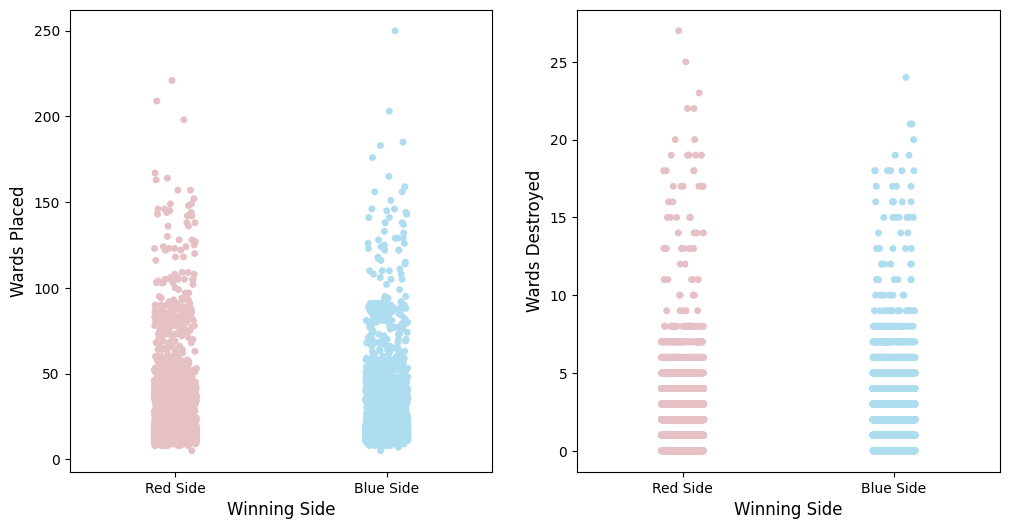

In [52]:
# 看插眼的資料與紅藍方勝利的分布。 點狀圖
shade = ["#E5C1C5", "#AEDDEF"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.stripplot(x='blueWins', y='blueWardsPlaced', data=df, palette= shade, ax=ax[0])
sns.stripplot(x='blueWins', y='blueWardsDestroyed', data=df, palette= shade, ax=ax[1])
ax[0].set_xlabel('Winning Side', fontsize=12)
ax[0].set_ylabel('Wards Placed', fontsize=12)
ax[1].set_xlabel('Winning Side', fontsize=12)
ax[1].set_ylabel('Wards Destroyed', fontsize=12)
plt.show()


In [56]:
# 看紅藍方各自的的插眼數量與勝利的關係
display(df[df['blueWins'] == 'Red Side'][['blueWardsPlaced', 'blueWardsDestroyed', 'redWardsPlaced', 'redWardsDestroyed']].describe())
display(df[df['blueWins'] == 'Blue Side'][['blueWardsPlaced', 'blueWardsDestroyed', 'redWardsPlaced', 'redWardsDestroyed']].describe())


,blueWardsPlaced,blueWardsDestroyed,redWardsPlaced,redWardsDestroyed
count,4949.000000,4949.000000,4949.000000,4949.000000
mean,22.286725,2.728834,22.804001,2.841382
std,18.431405,2.185427,18.745584,2.140218
min,5.000000,0.000000,7.000000,0.000000
25%,14.000000,1.000000,15.000000,1.000000
50%,16.000000,2.000000,17.000000,3.000000
75%,20.000000,4.000000,20.000000,4.000000
max,221.000000,27.000000,276.000000,24.000000


,blueWardsPlaced,blueWardsDestroyed,redWardsPlaced,redWardsDestroyed
count,4930.000000,4930.000000,4930.000000,4930.000000
mean,22.289858,2.921298,21.930223,2.604462
std,17.597520,2.160410,18.154932,2.130111
min,5.000000,0.000000,6.000000,0.000000
25%,15.000000,2.000000,14.000000,1.000000
50%,17.000000,3.000000,16.000000,2.000000
75%,20.000000,4.000000,19.000000,3.000000
max,250.000000,24.000000,268.000000,24.000000


- 從點狀圖可以看到有少數場次的插眼觸量異常的高，這些過高的數量可能表示這場遊戲有問題
- 從數據來看考已發現勝利的隊伍 插眼數量會較多一些，在遊戲中這樣也比較能觀察對方的動向，預防 gank 的發生或者地圖物件的搶奪

### - 首殺

In [88]:
df_FirstBlood = df[['blueWins','blueFirstBlood','redFirstBlood']].copy()
# 看數量
print(df_FirstBlood['blueFirstBlood'].value_counts())
print(df_FirstBlood['redFirstBlood'].value_counts())
# 確認兩個特徵比對沒有問題 只需要取用一個即可

blueFirstBlood
1    4987
0    4892
Name: count, dtype: int64
redFirstBlood
0    4987
1    4892
Name: count, dtype: int64


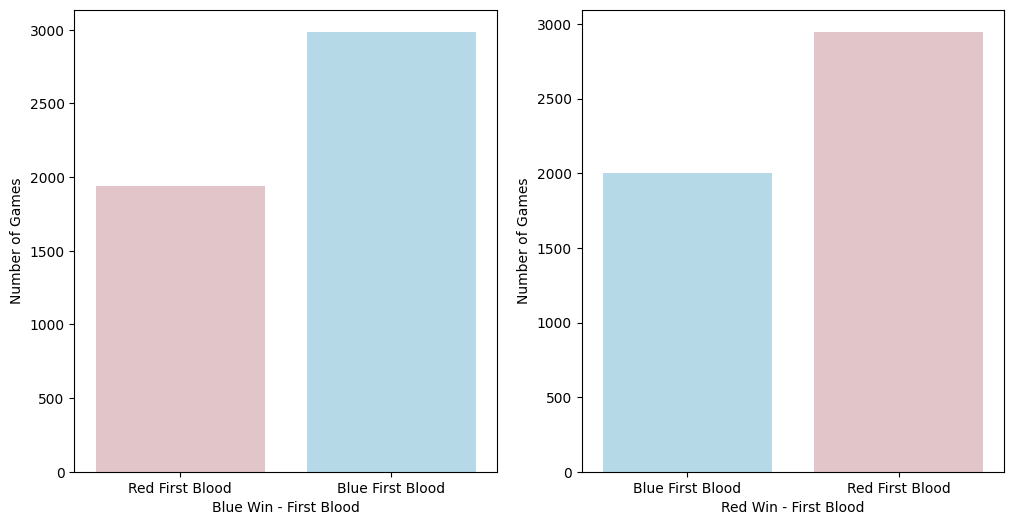

In [89]:
shade = ["#E5C1C5", "#AEDDEF"]
shade_reversed = ["#AEDDEF", "#E5C1C5"]

df_FirstBlood['blueFirstBlood'] = df_FirstBlood['blueFirstBlood'].map({1: 'Blue First Blood', 0:'Red First Blood'})

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df_FirstBlood[df_FirstBlood['blueWins'] == 'Blue Side'], x='blueFirstBlood', ax=ax[0], palette=shade)
sns.countplot(data=df_FirstBlood[df_FirstBlood['blueWins'] == 'Red Side'], x='blueFirstBlood', ax=ax[1], palette=shade_reversed)
ax[0].set_xlabel('Blue Win - First Blood')
ax[0].set_ylabel('Number of Games')
ax[1].set_xlabel('Red Win - First Blood')
ax[1].set_ylabel('Number of Games')
plt.show()

In [91]:
df_FirstBlood

,blueWins,blueFirstBlood,redFirstBlood
0,Red Side,Blue First Blood,0
1,Red Side,Red First Blood,1
2,Red Side,Red First Blood,1
3,Red Side,Red First Blood,1
4,Red Side,Red First Blood,1
...,...,...,...
9874,Blue Side,Blue First Blood,0
9875,Blue Side,Red First Blood,1
9876,Red Side,Red First Blood,1
9877,Red Side,Blue First Blood,0


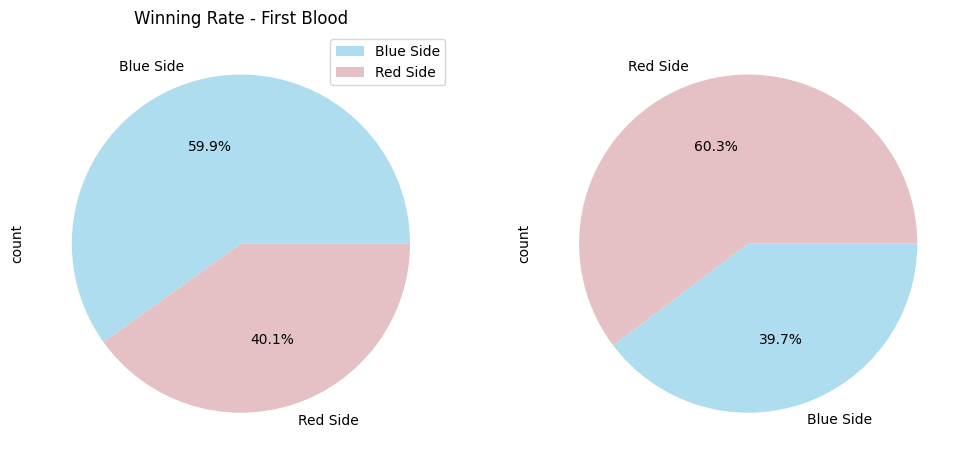

In [94]:
# 製作圓餅圖
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
df_FirstBlood[df_FirstBlood['blueFirstBlood'] == 'Blue First Blood']['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], colors=shade_reversed)
df_FirstBlood[df_FirstBlood['blueFirstBlood'] == 'Red First Blood']['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], colors=shade)
ax[0].set_title('Winning Rate - First Blood')
ax[0].legend(['Blue Side', 'Red Side'])
plt.show()

可以看到大多數贏得勝利得隊伍 在遊戲前有幾乎都會獲得首殺，基本上就有60 %的勝率

### - KDA
K: 擊殺
D: 死亡
A: 助攻

KDA 在遊戲中也是重要的判別特徵，可以表示玩家在遊戲中的表現，大多都會用 (K+A)/D 將玩家表現數據化

In [98]:
df_KDA = df[['blueWins','blueKills','blueDeaths','blueAssists','redKills','redDeaths','redAssists']].copy()
print(df_KDA.describe())

         blueKills   blueDeaths  blueAssists     redKills    redDeaths  \
count  9879.000000  9879.000000  9879.000000  9879.000000  9879.000000   
mean      6.183925     6.137666     6.645106     6.137666     6.183925   
std       3.011028     2.933818     4.064520     2.933818     3.011028   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.000000     4.000000     4.000000     4.000000     4.000000   
50%       6.000000     6.000000     6.000000     6.000000     6.000000   
75%       8.000000     8.000000     9.000000     8.000000     8.000000   
max      22.000000    22.000000    29.000000    22.000000    22.000000   

        redAssists  
count  9879.000000  
mean      6.662112  
std       4.060612  
min       0.000000  
25%       4.000000  
50%       6.000000  
75%       9.000000  
max      28.000000  


看起來紅藍方的 KDA 各自的平均值差不多

接下來一樣會進行紅藍雙方各自勝利時 自己隊伍與對方隊伍的比較

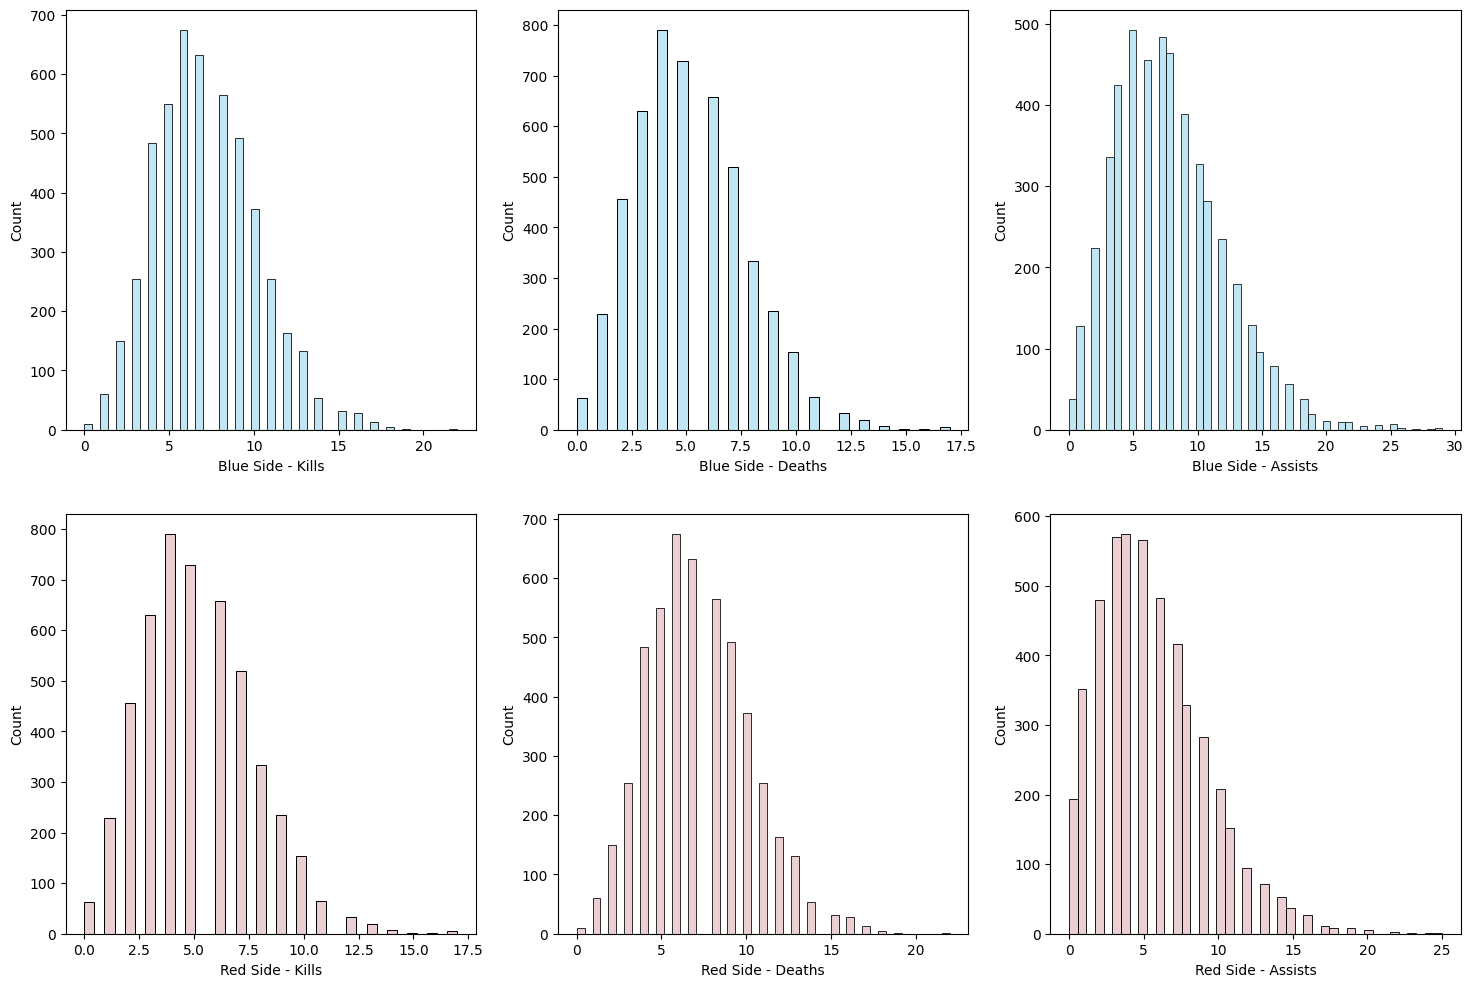

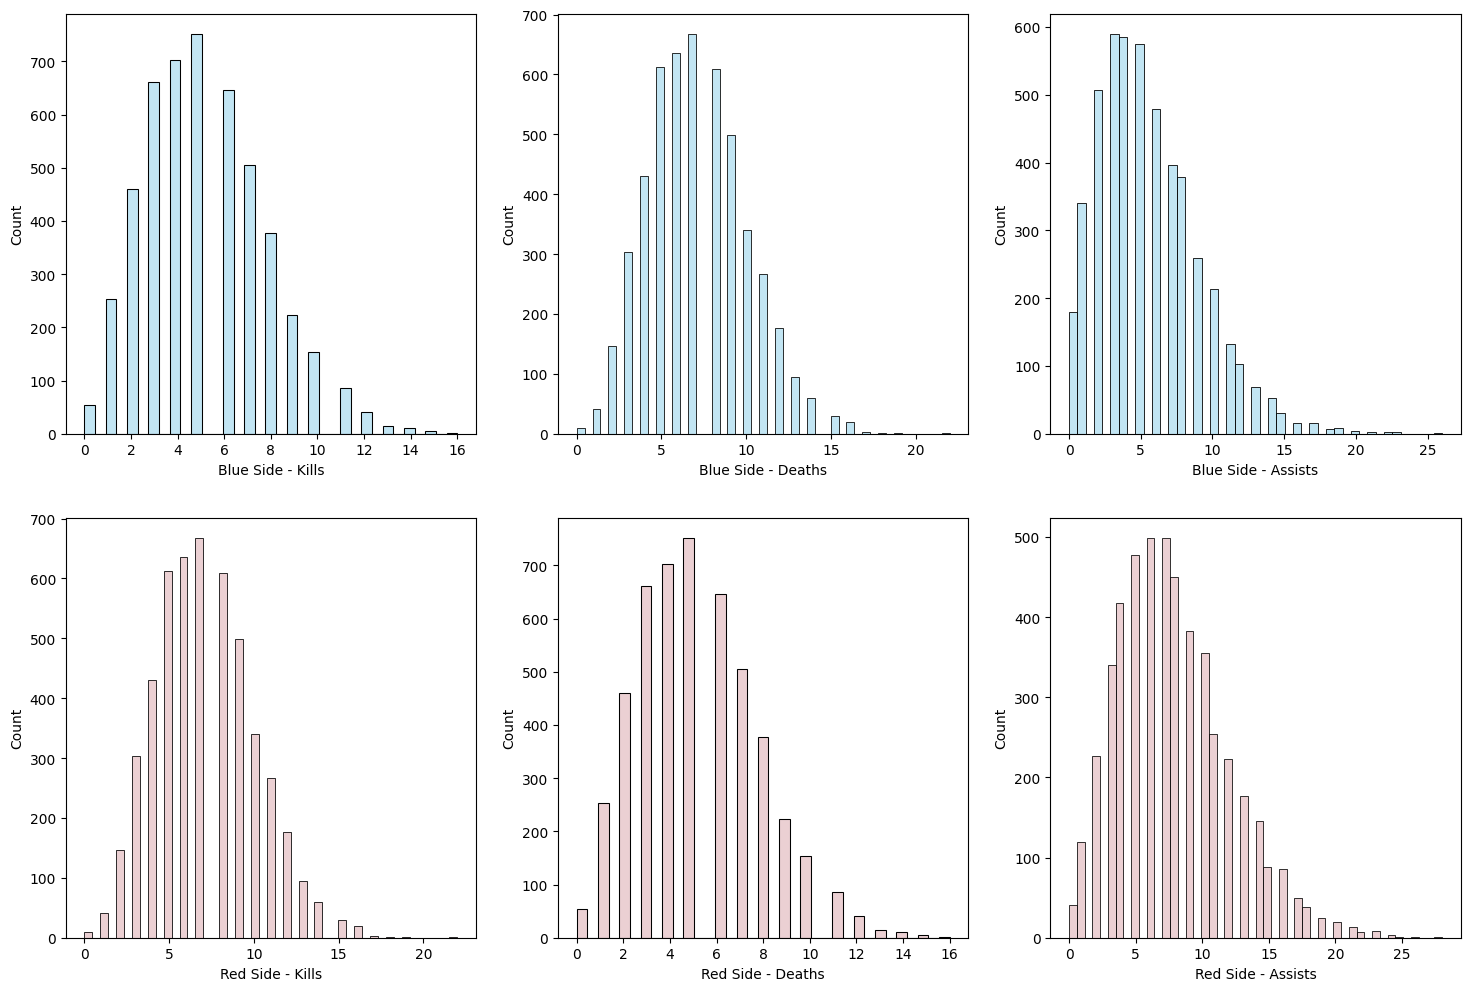

In [87]:
shade = ["#E5C1C5", "#AEDDEF"]
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Blue Side'], x='blueKills', ax=ax[0, 0], color=shade[1])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Blue Side'], x='blueDeaths', ax=ax[0, 1], color=shade[1])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Blue Side'], x='blueAssists', ax=ax[0, 2], color=shade[1])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Blue Side'], x='redKills', ax=ax[1, 0], color=shade[0])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Blue Side'], x='redDeaths', ax=ax[1, 1], color=shade[0])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Blue Side'], x='redAssists', ax=ax[1, 2], color=shade[0])
ax[0, 0].set_xlabel('Blue Side - Kills')
ax[0, 1].set_xlabel('Blue Side - Deaths')
ax[0, 2].set_xlabel('Blue Side - Assists')
ax[1, 0].set_xlabel('Red Side - Kills')
ax[1, 1].set_xlabel('Red Side - Deaths')
ax[1, 2].set_xlabel('Red Side - Assists')
plt.show()


fig, ax = plt.subplots(2, 3, figsize=(18, 12))
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Red Side'], x='blueKills', ax=ax[0, 0], color=shade[1])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Red Side'], x='blueDeaths', ax=ax[0, 1], color=shade[1])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Red Side'], x='blueAssists', ax=ax[0, 2], color=shade[1])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Red Side'], x='redKills', ax=ax[1, 0], color=shade[0])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Red Side'], x='redDeaths', ax=ax[1, 1], color=shade[0])
sns.histplot(data=df_KDA[df_KDA['blueWins'] == 'Red Side'], x='redAssists', ax=ax[1, 2], color=shade[0])
ax[0, 0].set_xlabel('Blue Side - Kills')
ax[0, 1].set_xlabel('Blue Side - Deaths')
ax[0, 2].set_xlabel('Blue Side - Assists')
ax[1, 0].set_xlabel('Red Side - Kills')
ax[1, 1].set_xlabel('Red Side - Deaths')
ax[1, 2].set_xlabel('Red Side - Assists')
plt.show()

這邊可以看到 其實 KDA 三個部分都還是集中在 10 以下，只有極少數會超過 10 甚至超過 20

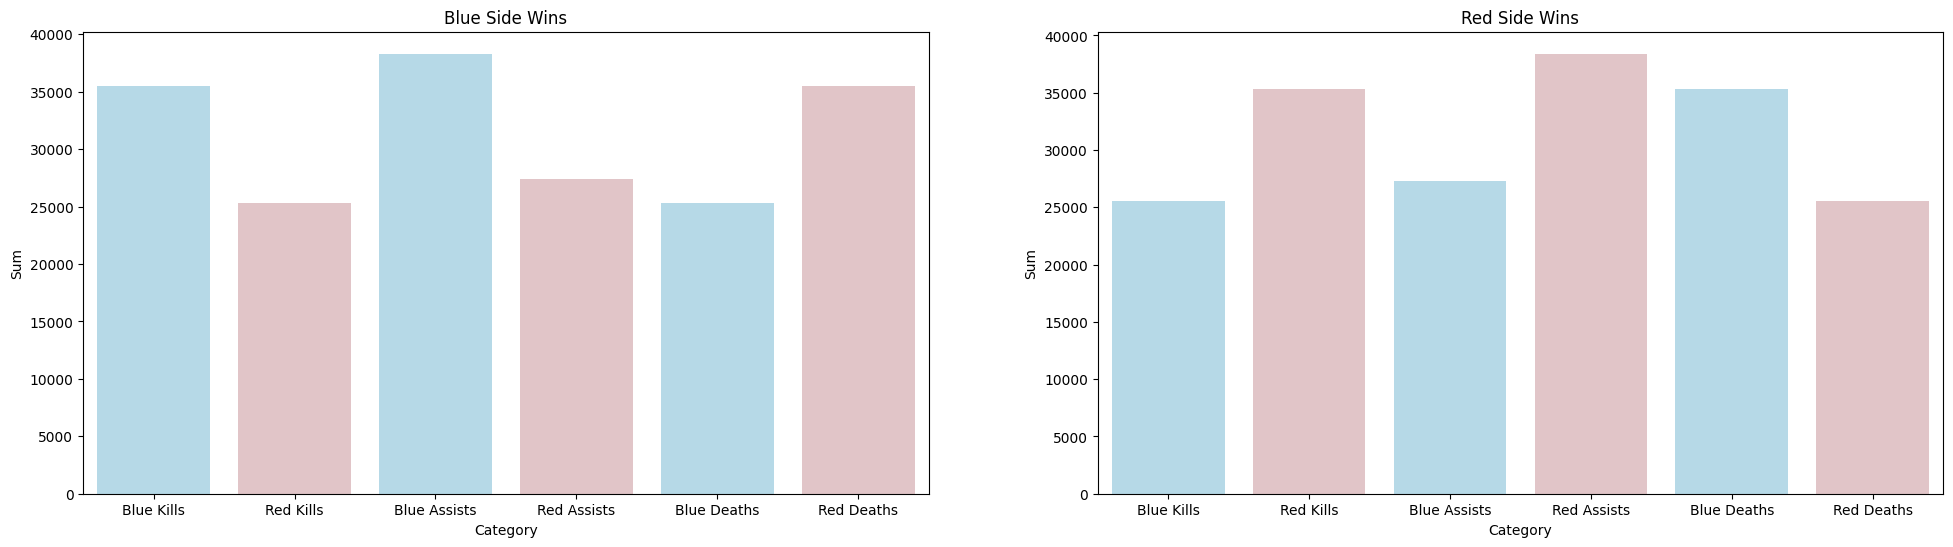

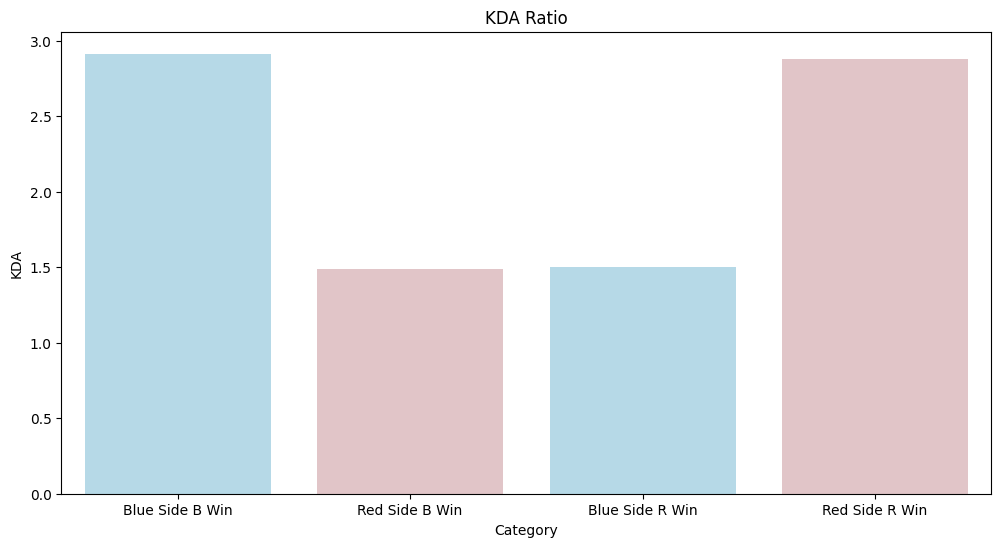

In [99]:
# 計算若藍方獲勝時的總殺敵數、死亡數、助攻數
blue_wins_data = df_KDA[df_KDA['blueWins'] == 'Blue Side']

blue_kills_sum = blue_wins_data['blueKills'].sum()
blue_deaths_sum = blue_wins_data['blueDeaths'].sum()
blue_assists_sum = blue_wins_data['blueAssists'].sum()
red_kills_sum = blue_wins_data['redKills'].sum()
red_deaths_sum = blue_wins_data['redDeaths'].sum()
red_assists_sum = blue_wins_data['redAssists'].sum()
blue_wins_blue_KDA = (blue_kills_sum + blue_assists_sum) / blue_deaths_sum
blue_wins_red_KDA = (red_kills_sum + red_assists_sum) / red_deaths_sum

data_blue_wins = {
    'Category': ['Blue Kills', 'Red Kills', 'Blue Assists', 'Red Assists', 'Blue Deaths', 'Red Deaths'],
    'Sum': [blue_kills_sum, red_kills_sum, blue_assists_sum, red_assists_sum, blue_deaths_sum, red_deaths_sum]
}
df_blue_win_sums = pd.DataFrame(data_blue_wins)

# 計算若紅方獲勝時的總殺敵數、死亡數、助攻數
red_wins_data = df_KDA[df_KDA['blueWins'] == 'Red Side']

blue_kills_sum = red_wins_data['blueKills'].sum()
blue_deaths_sum = red_wins_data['blueDeaths'].sum()
blue_assists_sum = red_wins_data['blueAssists'].sum()
red_kills_sum = red_wins_data['redKills'].sum()
red_deaths_sum = red_wins_data['redDeaths'].sum()
red_assists_sum = red_wins_data['redAssists'].sum()
red_wins_blue_KDA = (blue_kills_sum + blue_assists_sum) / blue_deaths_sum
red_wins_red_KDA = (red_kills_sum + red_assists_sum) / red_deaths_sum

data_red_wins = {
    'Category': ['Blue Kills', 'Red Kills', 'Blue Assists', 'Red Assists', 'Blue Deaths', 'Red Deaths'],
    'Sum': [blue_kills_sum, red_kills_sum, blue_assists_sum, red_assists_sum, blue_deaths_sum, red_deaths_sum]
}
df_red_win_sums = pd.DataFrame(data_red_wins)

# 製作圖表
fig, ax = plt.subplots(1, 2, figsize=(24, 6))
sns.barplot(data=df_blue_win_sums, x='Category', y='Sum', ax=ax[0], palette=shade_reversed)
sns.barplot(data=df_red_win_sums, x='Category', y='Sum', ax=ax[1], palette=shade_reversed)
ax[0].set_title('Blue Side Wins')
ax[1].set_title('Red Side Wins')
plt.show()

# 製作 KDA 圖表
data_KDA = {
    'Category': ['Blue Side B Win', 'Red Side B Win','Blue Side R Win', 'Red Side R Win'],
    'KDA': [blue_wins_blue_KDA, blue_wins_red_KDA, red_wins_blue_KDA, red_wins_red_KDA]
}
df_KDA = pd.DataFrame(data_KDA)

fig = plt.figure(figsize=(12,6))
sns.barplot(data=df_KDA, x='Category', y='KDA', palette=shade_reversed)
plt.title('KDA Ratio')
plt.show()



藉由上面的圖表可以知道隊伍勝負的關係與 KDA 有極大的關聯，獲勝的隊伍前10分鐘的 KDA 幾乎快要是輸的隊伍的兩倍

而且從遊戲前10分鐘的擊殺、助攻、死亡的數據來看就可以明顯看出獲勝的是哪方

### - 野區
相較上面幾個比較事項，野區就有明顯的紅藍分之別
在地圖中有許多帶有不同增益效果的野怪，他們所在的位置會有各自偏向的方向
以下為幾個是比較具代表性的野怪:
* 巴隆(Baron Nashor): 比較偏向右上的紅方，但出入口卻是面向左下的藍方
* 飛龍(Dragons): 比較偏向左下的藍方，但出入口卻是面向右上的藍方
* 諭示者(Herald): 比較偏向右上的紅方，但出入口卻是面向左下的藍方
* 中立野怪: 有6種中立野怪，遠古石甲蟲、暗影狼群、深紅鋒喙鳥群、魔沼蛙、峽谷迅捷蟹、蒼藍雕紋魔像、緋紅印記樹怪，位置散佈在紅藍方的野區

由於這邊只記錄到遊戲前10分鐘，巴隆尚未出現，所以以下只會有其於3種的擊殺數量紀錄

EliteMonsters(菁英野怪) 為Dragons + Heralds 的數量

In [12]:
df_Neutral_Goals = df[['blueWins','blueEliteMonsters','blueDragons','blueHeralds','redEliteMonsters','redDragons','redHeralds']].copy()
df_Neutral_Goals.describe()

,blueEliteMonsters,blueDragons,blueHeralds,redEliteMonsters,redDragons,redHeralds
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.549954,0.361980,0.187974,0.573135,0.413098,0.160036
std,0.625527,0.480597,0.390712,0.626482,0.492415,0.366658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000


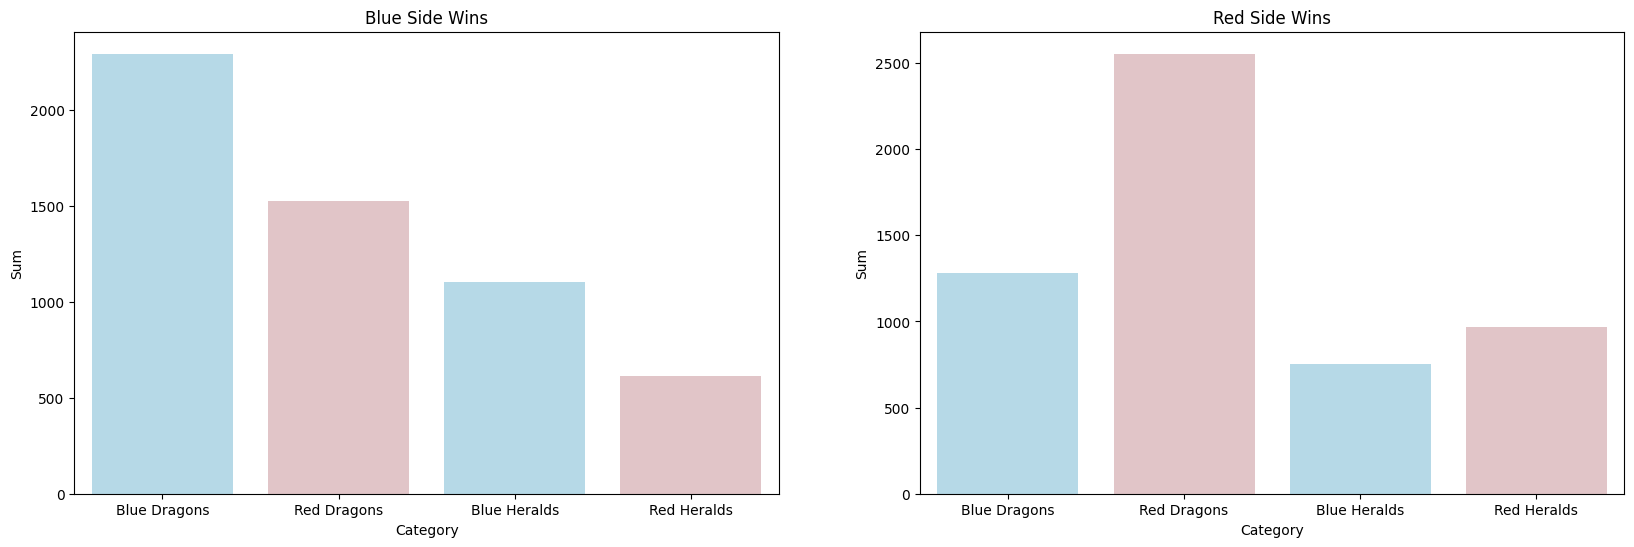

In [15]:
shade = ["#E5C1C5", "#AEDDEF"]
shade_reversed = ["#AEDDEF", "#E5C1C5"]
# 這邊跟 KDA 一樣，先計算藍方獲勝時的總數量
blue_wins_data = df_Neutral_Goals[df_Neutral_Goals['blueWins'] == 'Blue Side']

blue_dragons_sum = blue_wins_data['blueDragons'].sum()
blue_heralds_sum = blue_wins_data['blueHeralds'].sum()
red_dragons_sum = blue_wins_data['redDragons'].sum()
red_heralds_sum = blue_wins_data['redHeralds'].sum()

data_blue_wins = {
    'Category': ['Blue Dragons', 'Red Dragons', 'Blue Heralds', 'Red Heralds'],
    'Sum': [blue_dragons_sum, red_dragons_sum, blue_heralds_sum, red_heralds_sum]
}
df_blue_win_sums = pd.DataFrame(data_blue_wins)

# 計算若紅方獲勝時的總數量
red_wins_data = df_Neutral_Goals[df_Neutral_Goals['blueWins'] == 'Red Side']

blue_dragons_sum = red_wins_data['blueDragons'].sum()
blue_heralds_sum = red_wins_data['blueHeralds'].sum()
red_dragons_sum = red_wins_data['redDragons'].sum()
red_heralds_sum = red_wins_data['redHeralds'].sum()

data_red_wins = {
    'Category': ['Blue Dragons', 'Red Dragons', 'Blue Heralds', 'Red Heralds'],
    'Sum': [blue_dragons_sum, red_dragons_sum, blue_heralds_sum, red_heralds_sum]
}
df_red_win_sums = pd.DataFrame(data_red_wins)


# 製作圖表
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(data=df_blue_win_sums, x='Category', y='Sum', ax=ax[0], palette=shade_reversed)
sns.barplot(data=df_red_win_sums, x='Category', y='Sum', ax=ax[1], palette=shade_reversed)
ax[0].set_title('Blue Side Wins')
ax[1].set_title('Red Side Wins')
plt.show()


從以上圖形就可以明顯看出因野怪位置的差異造成的數據
先看飛龍的部分 就算在藍方贏的狀態下，紅方其實也吃了不少飛龍，但是在紅方贏的狀態下由於飛龍的出入口朝向紅方，所以藍方吃到飛龍的數量明顯低很多

再來是諭示者的部分，一樣因為出入口朝向藍方所以在紅方贏的狀況下，藍方也還是吃了不少諭示者，反觀藍方贏的情況下，紅方的諭示者數量也是比較低的

接下來會想要比較若飛龍與諭示者同時都有獲得的狀態下，紅藍方的數量比例會不會也有差距，是否也關乎到這兩個菁英野怪在雙方隊伍中是否一樣重要

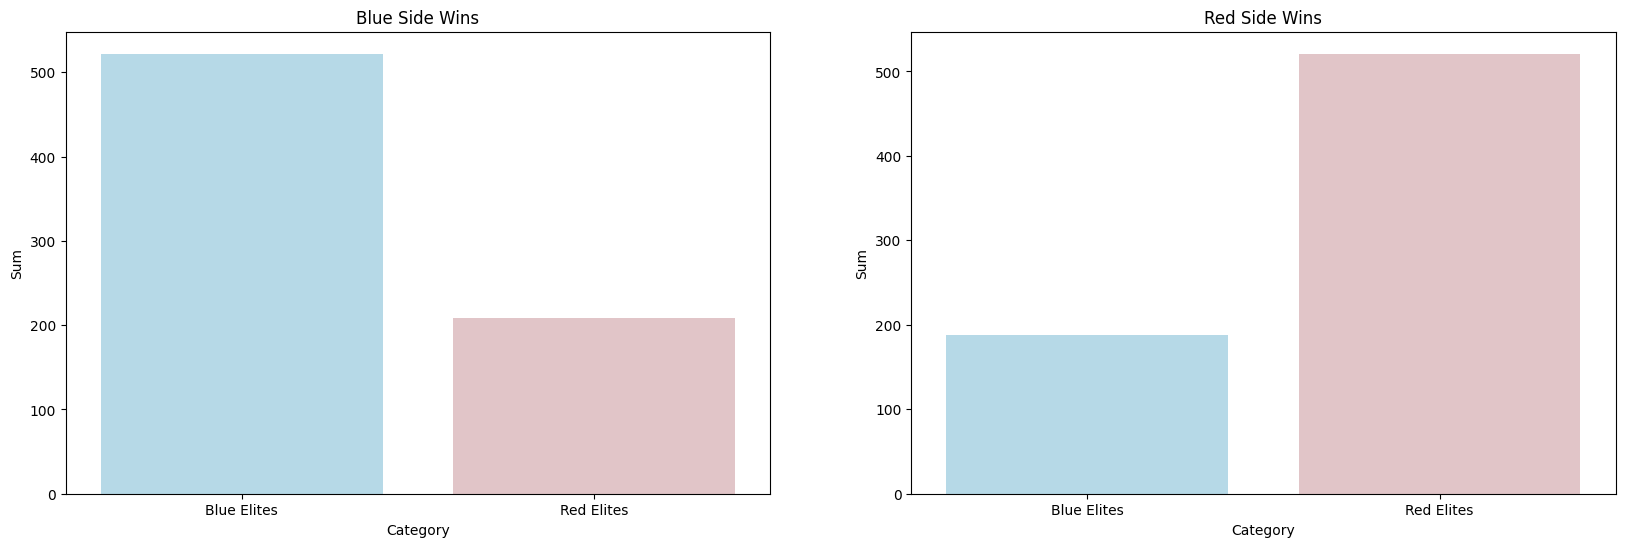

In [ ]:
#  有幾筆資料是藍方有兩個野怪的
blue_elites_sum = blue_wins_data[blue_wins_data['blueEliteMonsters'] == 2].shape[0]
red_elites_sum = blue_wins_data[blue_wins_data['redEliteMonsters'] == 2].shape[0]

data_blue_wins = {
    'Category': ['Blue Elites', 'Red Elites'],
    'Sum': [blue_elites_sum, red_elites_sum]
}

df_blue_win_sums = pd.DataFrame(data_blue_wins)

blue_elites_sum = red_wins_data[red_wins_data['blueEliteMonsters'] == 2].shape[0]
red_elites_sum = red_wins_data[red_wins_data['redEliteMonsters'] == 2].shape[0]

data_red_wins = {
    'Category': ['Blue Elites', 'Red Elites'],
    'Sum': [blue_elites_sum, red_elites_sum]
}

df_red_win_sums = pd.DataFrame(data_red_wins)

# 製作圖表
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(data=df_blue_win_sums, x='Category', y='Sum', ax=ax[0], palette=shade_reversed)
sns.barplot(data=df_red_win_sums, x='Category', y='Sum', ax=ax[1], palette=shade_reversed)
ax[0].set_title('Blue Side Wins')
ax[1].set_title('Red Side Wins')
plt.show()


接下來這邊要探討 紅藍隊分別在吃到0~2隻菁英野怪時的勝率變化，是否因為吃到菁英野怪會讓勝率上升呢?

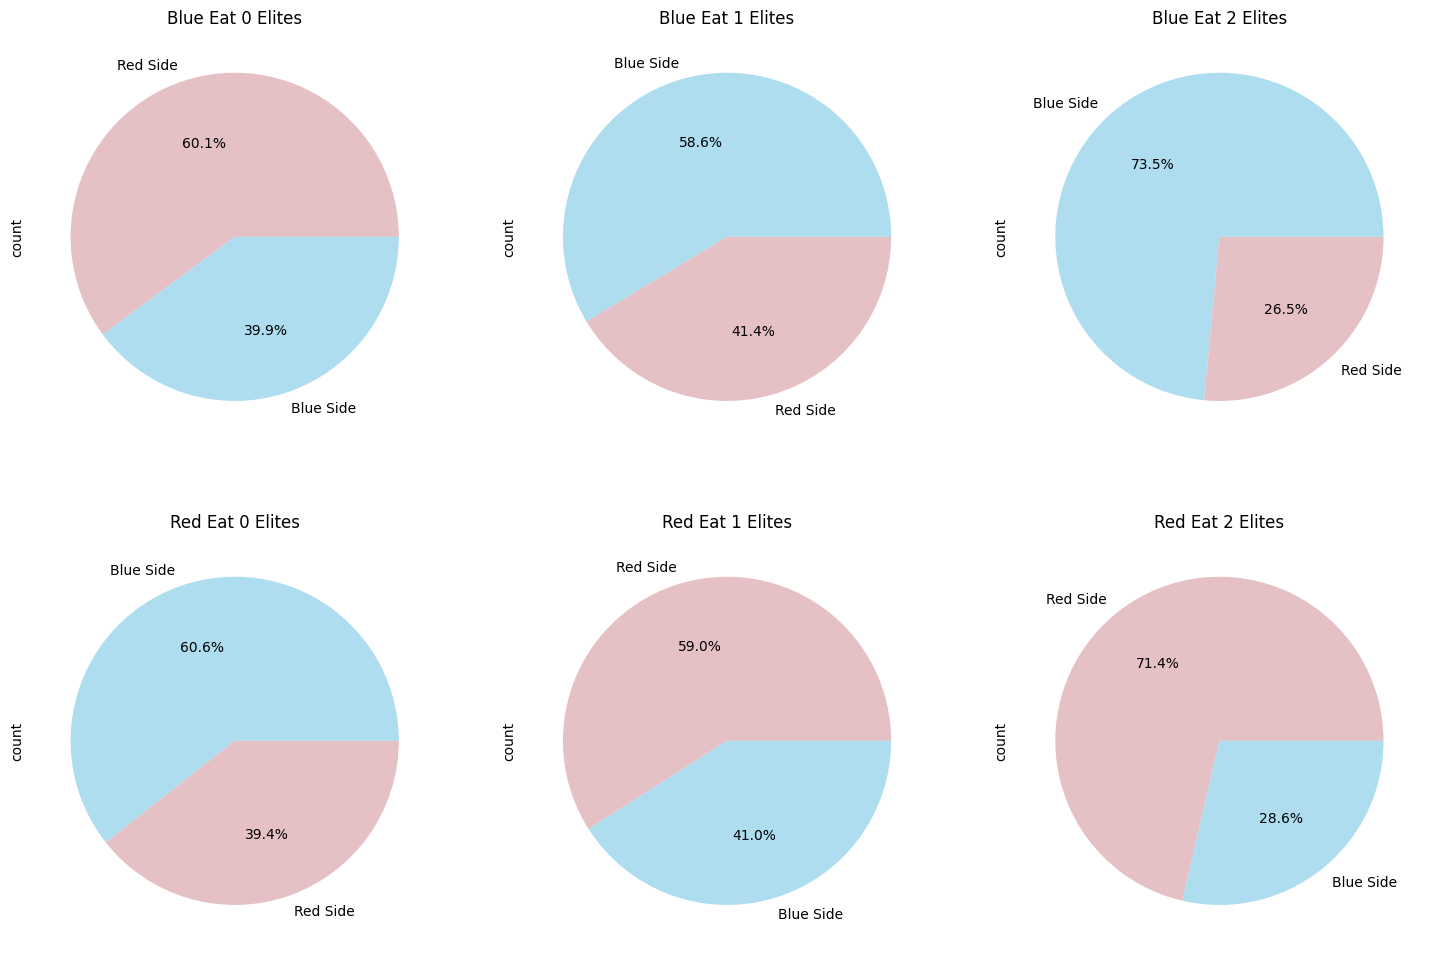

In [ ]:
# 製作圓餅圖 6 個圖

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
df_Neutral_Goals[df_Neutral_Goals['blueEliteMonsters'] == 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,0], colors=shade)
df_Neutral_Goals[df_Neutral_Goals['blueEliteMonsters'] == 1]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,1], colors=shade_reversed)
df_Neutral_Goals[df_Neutral_Goals['blueEliteMonsters'] == 2]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,2], colors=shade_reversed)

df_Neutral_Goals[df_Neutral_Goals['redEliteMonsters'] == 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,0], colors=shade_reversed)
df_Neutral_Goals[df_Neutral_Goals['redEliteMonsters'] == 1]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,1], colors=shade)
df_Neutral_Goals[df_Neutral_Goals['redEliteMonsters'] == 2]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,2], colors=shade)
ax[0,0].set_title('Blue Eat 0 Elites')
ax[0,1].set_title('Blue Eat 1 Elites')
ax[0,2].set_title('Blue Eat 2 Elites')
ax[1,0].set_title('Red Eat 0 Elites')
ax[1,1].set_title('Red Eat 1 Elites')
ax[1,2].set_title('Red Eat 2 Elites')
plt.show()

由這邊可以看出若單純只是計算在遊戲前10分鐘吃掉菁英野怪的數量的話，
- 一隻都沒有吃到，勝率只會有 40% 左右
- 只有吃到其中一隻，勝率就會直接上升到 60%
- 若是兩隻都有吃到，會直接上升到 71~73%左右

所以若是想要前期就能擬定遊戲戰局，那請至少要吃到一隻菁英野怪，或者是阻止對方吃到任何一隻，這樣就能有效提高勝率

接下來再來觀察，若是只能吃一隻的時候，紅藍雙方究竟要吃飛龍或者是諭示者呢?

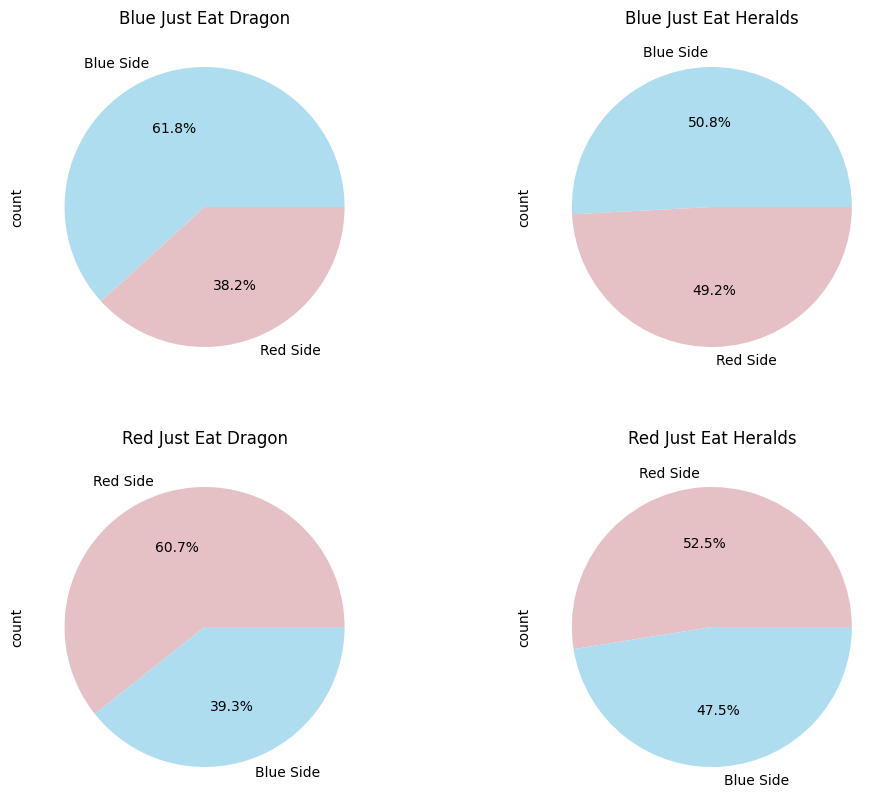

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
df_Neutral_Goals[(df_Neutral_Goals['blueEliteMonsters'] == 1) & (df_Neutral_Goals['blueDragons'] == 1)]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,0], colors=shade_reversed)
df_Neutral_Goals[(df_Neutral_Goals['blueEliteMonsters'] == 1) & (df_Neutral_Goals['blueHeralds'] == 1)]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,1], colors=shade_reversed)

df_Neutral_Goals[(df_Neutral_Goals['redEliteMonsters'] == 1) & (df_Neutral_Goals['redDragons'] == 1)]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,0], colors=shade)
df_Neutral_Goals[(df_Neutral_Goals['redEliteMonsters'] == 1) & (df_Neutral_Goals['redHeralds'] == 1)]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,1], colors=shade)
ax[0,0].set_title('Blue Just Eat Dragon')
ax[0,1].set_title('Blue Just Eat Heralds')
ax[1,0].set_title('Red Just Eat Dragon')
ax[1,1].set_title('Red Just Eat Heralds')
plt.show()

這邊可以很明顯看出，在只有吃一隻的狀況下，吃掉飛龍的那方勝率明顯高很多，會來到60%

但是選擇吃諭示者的話，勝率卻微妙的停留在 50.8~52.5%而已，幾乎不太會影響勝率

另外也可以看出，因為藍方比較難吃到飛龍的原因(出入口面向紅方)，所以要是藍方吃到飛龍，藍方的勝率也高了一些些

反之，紅方較難吃到的諭示者若被紅方吃到的話，勝率也會比藍方吃到也獲勝時高出了一些些

### - 吃兵數、金錢、經驗差距
接下來會把剩餘的項目放在一起，相較於上面比較無法透過直觀數據直接表示勝負關鍵的資料來說，以下這幾項就是比較能直接影響到勝負的關鍵
- TotalGold
- AvgLevel
- TotalExperience
- TotalMinionsKilled 
- TotalJungleMinionsKilled
- GoldDiff 
- ExperienceDiff
- CSPerMin       
- GoldPerMin   

以及我們有事先處理好的
- GoldDiffSituation
- ExperienceDiffSituation

In [11]:
# 看一下金錢與經驗的差距
df_diff = df[['blueWins','blueGoldDiff','blueExperienceDiff','redGoldDiff','redExperienceDiff', 'blueGoldDiffSituation', 'redGoldDiffSituation', 'blueExperienceDiffSituation', 'redExperienceDiffSituation']].copy()
display(df_diff.head())
df_diff.describe()

,blueWins,blueGoldDiff,blueExperienceDiff,redGoldDiff,redExperienceDiff,blueGoldDiffSituation,redGoldDiffSituation,blueExperienceDiffSituation,redExperienceDiffSituation
0,Red Side,643,-8,-643,8,1,0,0,1
1,Red Side,-2908,-1173,2908,1173,0,1,0,1
2,Red Side,-1172,-1033,1172,1033,0,1,0,1
3,Red Side,-1321,-7,1321,7,0,1,0,1
4,Red Side,-1004,230,1004,-230,0,1,1,0


,blueGoldDiff,blueExperienceDiff,redGoldDiff,redExperienceDiff,blueGoldDiffSituation,redGoldDiffSituation,blueExperienceDiffSituation,redExperienceDiffSituation
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,14.414111,-33.620306,-14.414111,33.620306,0.502278,0.497925,0.492459,0.507642
std,2453.349179,1920.370438,2453.349179,1920.370438,0.500020,0.500021,0.499968,0.499967
min,-10830.000000,-9333.000000,-11467.000000,-8348.000000,0.000000,0.000000,0.000000,0.000000
25%,-1585.500000,-1290.500000,-1596.000000,-1212.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,-28.000000,-14.000000,28.000000,1.000000,0.000000,0.000000,1.000000
75%,1596.000000,1212.000000,1585.500000,1290.500000,1.000000,1.000000,1.000000,1.000000
max,11467.000000,8348.000000,10830.000000,9333.000000,1.000000,1.000000,1.000000,1.000000


可以明顯知道 diff 系列紅藍方的數據就差在負號以及0或1而已，所以這邊可以單純取用一邊的數據再來判別正負號就可以了解紅藍方的關係，減少數據的計算

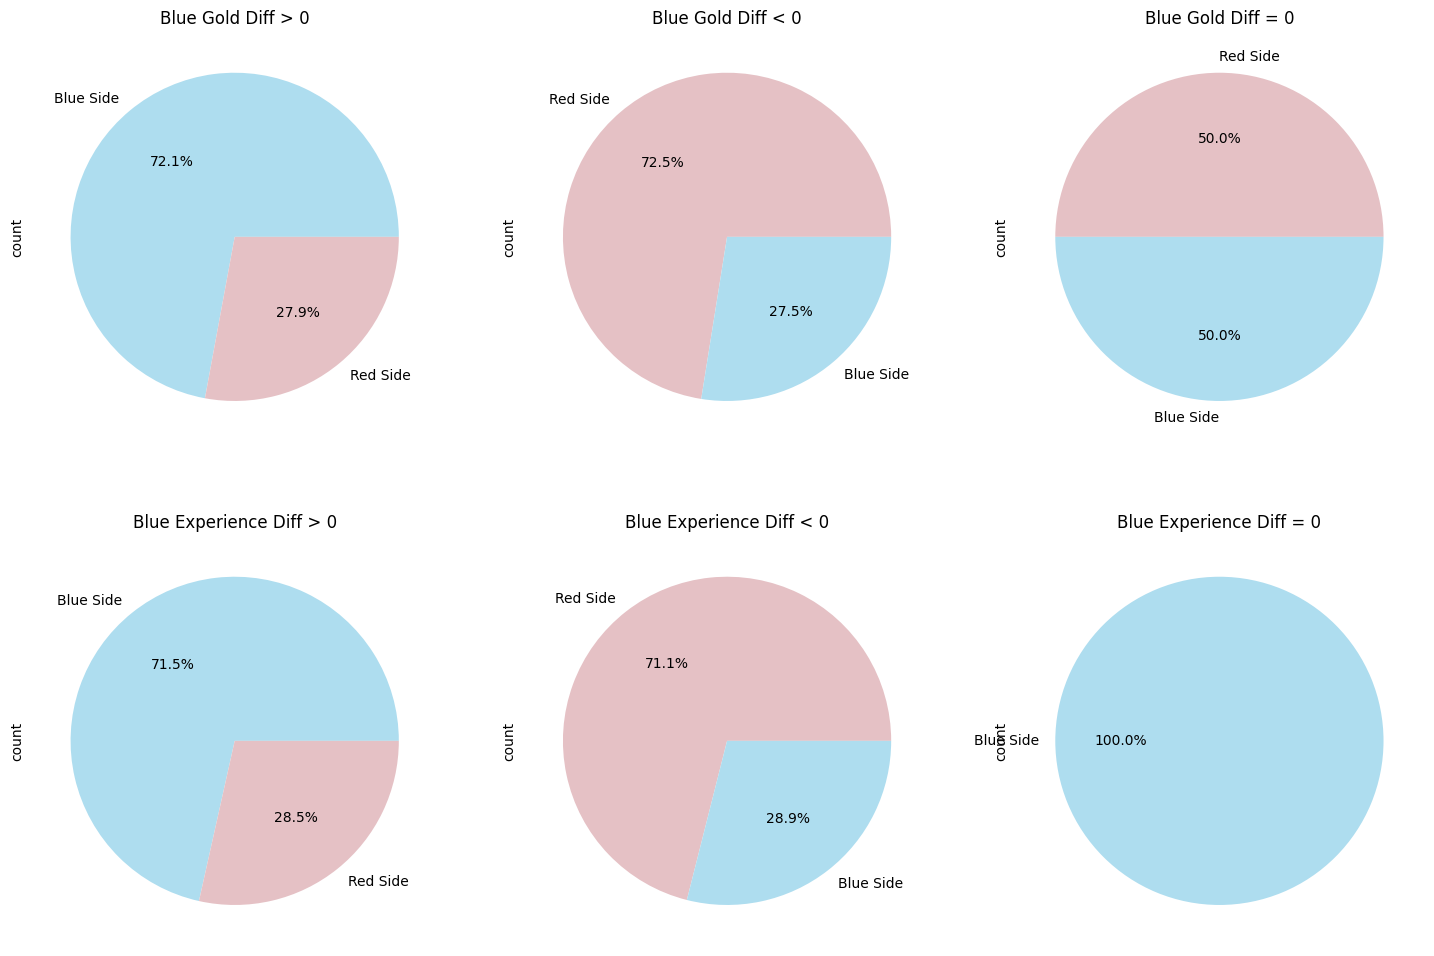

blueGoldDiffSituation          3577
blueExperienceDiffSituation    3479
redGoldDiffSituation           1354
redExperienceDiffSituation     1452
dtype: int64

blueGoldDiffSituation          1385
blueExperienceDiffSituation    1386
redGoldDiffSituation           3565
redExperienceDiffSituation     3563
dtype: int64

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
df_diff[df_diff['blueGoldDiff'] > 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,0], colors=shade_reversed)
df_diff[df_diff['blueGoldDiff'] < 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,1], colors=shade)
df_diff[df_diff['blueGoldDiff'] == 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0,2], colors=shade)

df_diff[df_diff['blueExperienceDiff'] > 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,0], colors=shade_reversed)
df_diff[df_diff['blueExperienceDiff'] < 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,1], colors=shade)
df_diff[df_diff['blueExperienceDiff'] == 0]['blueWins'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1,2], colors=shade_reversed)
ax[0,0].set_title('Blue Gold Diff > 0')
ax[0,1].set_title('Blue Gold Diff < 0')
ax[0,2].set_title('Blue Gold Diff = 0')
ax[1,0].set_title('Blue Experience Diff > 0')
ax[1,1].set_title('Blue Experience Diff < 0')
ax[1,2].set_title('Blue Experience Diff = 0')
plt.show()

display(df_diff[df_diff['blueWins'] == 'Blue Side'][['blueGoldDiffSituation', 'blueExperienceDiffSituation', 'redGoldDiffSituation', 'redExperienceDiffSituation']].sum())
df_diff[df_diff['blueWins'] == 'Red Side'][['blueGoldDiffSituation', 'blueExperienceDiffSituation', 'redGoldDiffSituation', 'redExperienceDiffSituation']].sum()

藉由 diff 系列的數據可以看到，若是在遊戲的前 10 分鐘再金錢或者經驗上有優勢，基本上就已經有 70% 左右的勝率

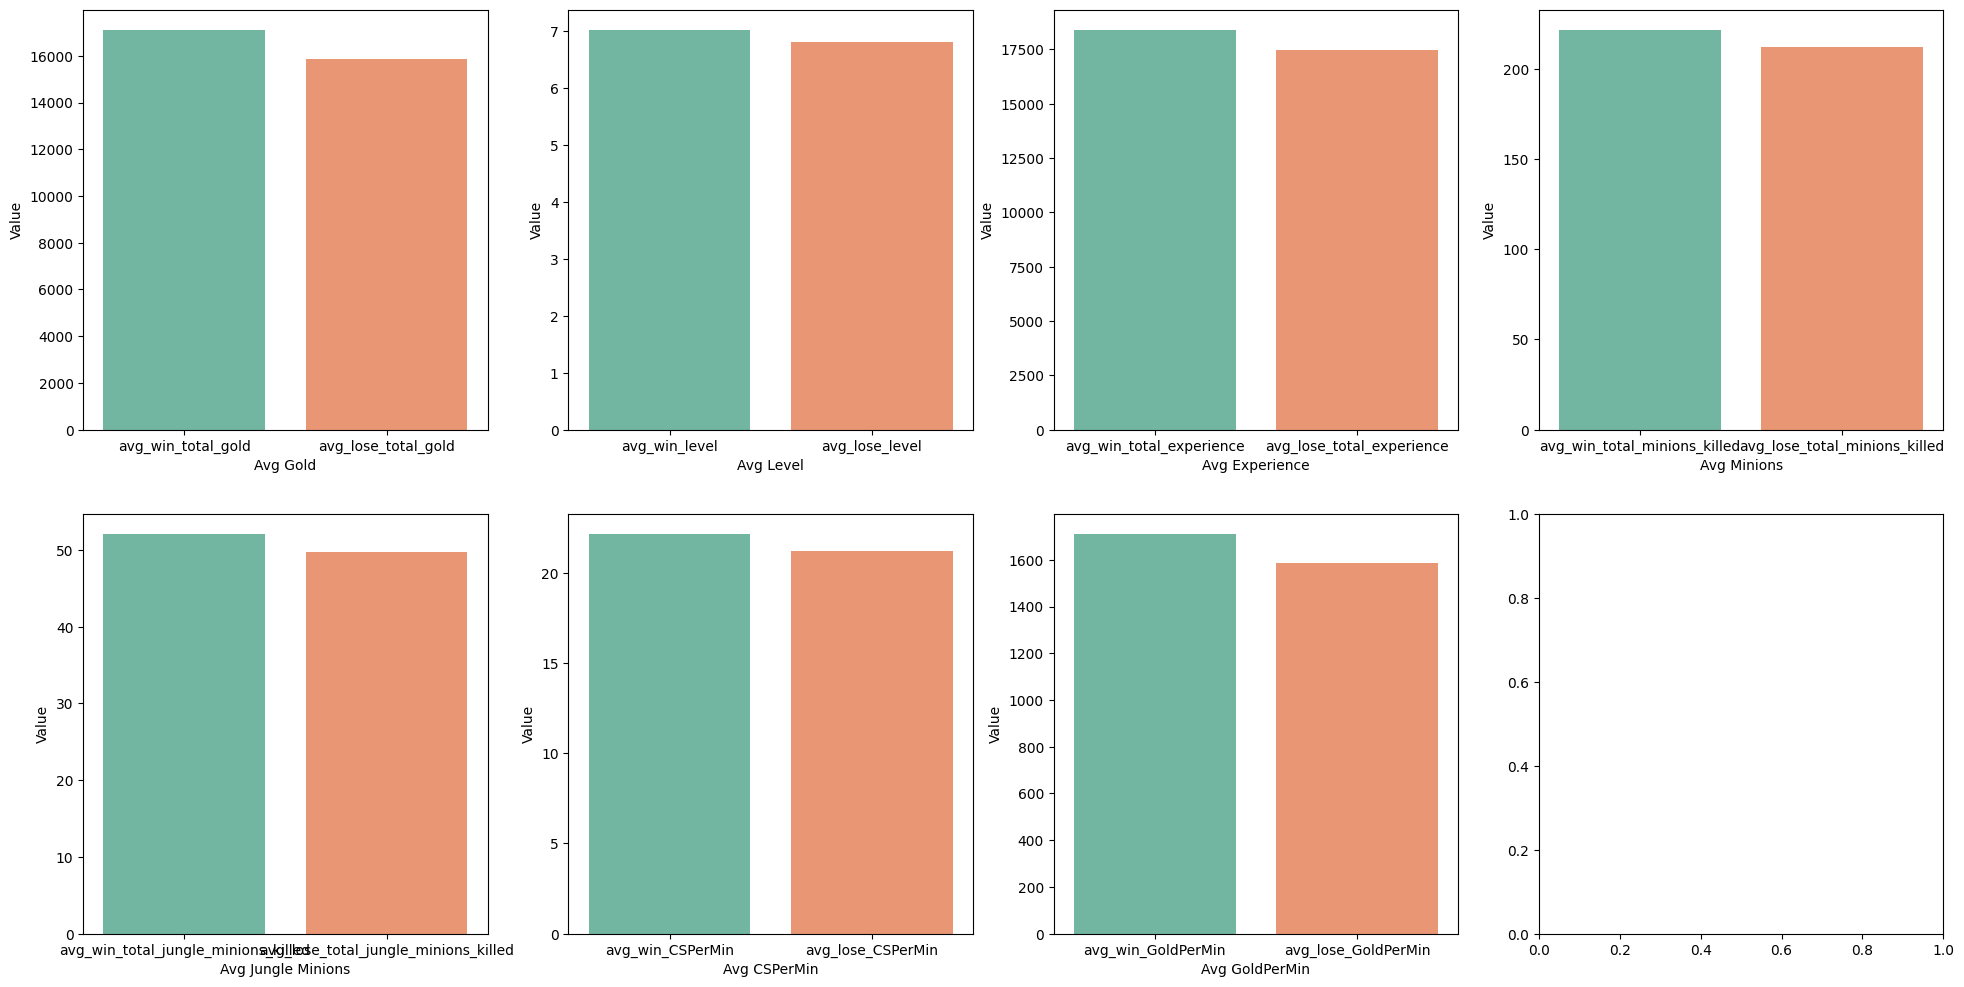

In [47]:

# - TotalGold
# - AvgLevel
# - TotalExperience
# - TotalMinionsKilled 
# - TotalJungleMinionsKilled
# - CSPerMin       
# - GoldPerMin   

df_avg = df[['blueWins','blueTotalGold','blueAvgLevel','blueTotalExperience','blueTotalMinionsKilled','blueTotalJungleMinionsKilled','blueCSPerMin','blueGoldPerMin','redTotalGold',
             'redAvgLevel','redTotalExperience','redTotalMinionsKilled','redTotalJungleMinionsKilled','redCSPerMin','redGoldPerMin']].copy()

blue_wins_data = df_avg[df_avg['blueWins'] == 'Blue Side']
red_wins_data = df_avg[df_avg['blueWins'] == 'Red Side']
# 算平均值
avg_win_total_gold = (blue_wins_data['blueTotalGold'].sum() + red_wins_data['redTotalGold'].sum()) / df_diff.shape[0]
avg_lose_total_gold = (blue_wins_data['redTotalGold'].sum() + red_wins_data['blueTotalGold'].sum()) / df_diff.shape[0]

avg_win_level = (blue_wins_data['blueAvgLevel'].sum() + red_wins_data['redAvgLevel'].sum()) / df_diff.shape[0] 
avg_lose_level = (blue_wins_data['redAvgLevel'].sum() + red_wins_data['blueAvgLevel'].sum()) / df_diff.shape[0]

avg_win_total_experience = (blue_wins_data['blueTotalExperience'].sum() + red_wins_data['redTotalExperience'].sum()) / df_diff.shape[0]
avg_lose_total_experience = (blue_wins_data['redTotalExperience'].sum() + red_wins_data['blueTotalExperience'].sum()) / df_diff.shape[0]

avg_win_total_minions_killed = (blue_wins_data['blueTotalMinionsKilled'].sum() + red_wins_data['redTotalMinionsKilled'].sum()) / df_diff.shape[0]
avg_lose_total_minions_killed = (blue_wins_data['redTotalMinionsKilled'].sum() + red_wins_data['blueTotalMinionsKilled'].sum()) / df_diff.shape[0]

avg_win_total_jungle_minions_killed = (blue_wins_data['blueTotalJungleMinionsKilled'].sum() + red_wins_data['redTotalJungleMinionsKilled'].sum()) / df_diff.shape[0]
avg_lose_total_jungle_minions_killed = (blue_wins_data['redTotalJungleMinionsKilled'].sum() + red_wins_data['blueTotalJungleMinionsKilled'].sum()) / df_diff.shape[0]

avg_win_CSPerMin = (blue_wins_data['blueCSPerMin'].sum() + red_wins_data['redCSPerMin'].sum()) / df_diff.shape[0]
avg_lose_CSPerMin = (blue_wins_data['redCSPerMin'].sum() + red_wins_data['blueCSPerMin'].sum()) / df_diff.shape[0]

avg_win_GoldPerMin = (blue_wins_data['blueGoldPerMin'].sum() + red_wins_data['redGoldPerMin'].sum()) / df_diff.shape[0]
avg_lose_GoldPerMin = (blue_wins_data['redGoldPerMin'].sum() + red_wins_data['blueGoldPerMin'].sum()) / df_diff.shape[0]

# 製作圖表 avg_win_total_gold跟avg_lose_total_gold 做一個表
fig, ax = plt.subplots(2, 4, figsize=(24, 12))
sns.barplot(data=pd.DataFrame({'Avg Gold': ['avg_win_total_gold', 'avg_lose_total_gold'], 'Value': [avg_win_total_gold, avg_lose_total_gold]}), x='Avg Gold', y='Value', ax=ax[0,0], palette='Set2')
sns.barplot(data=pd.DataFrame({'Avg Level': ['avg_win_level', 'avg_lose_level'], 'Value': [avg_win_level, avg_lose_level]}), x='Avg Level', y='Value', ax=ax[0,1], palette='Set2')
sns.barplot(data=pd.DataFrame({'Avg Experience': ['avg_win_total_experience', 'avg_lose_total_experience'], 'Value': [avg_win_total_experience, avg_lose_total_experience]}), x='Avg Experience', y='Value', ax=ax[0,2], palette='Set2')
sns.barplot(data=pd.DataFrame({'Avg Minions': ['avg_win_total_minions_killed', 'avg_lose_total_minions_killed'], 'Value': [avg_win_total_minions_killed, avg_lose_total_minions_killed]}), x='Avg Minions', y='Value', ax=ax[0,3], palette='Set2')
sns.barplot(data=pd.DataFrame({'Avg Jungle Minions': ['avg_win_total_jungle_minions_killed', 'avg_lose_total_jungle_minions_killed'], 'Value': [avg_win_total_jungle_minions_killed, avg_lose_total_jungle_minions_killed]}), x='Avg Jungle Minions', y='Value', ax=ax[1,0], palette='Set2')
sns.barplot(data=pd.DataFrame({'Avg CSPerMin': ['avg_win_CSPerMin', 'avg_lose_CSPerMin'], 'Value': [avg_win_CSPerMin, avg_lose_CSPerMin]}), x='Avg CSPerMin', y='Value', ax=ax[1,1], palette='Set2')
sns.barplot(data=pd.DataFrame({'Avg GoldPerMin': ['avg_win_GoldPerMin', 'avg_lose_GoldPerMin'], 'Value': [avg_win_GoldPerMin, avg_lose_GoldPerMin]}), x='Avg GoldPerMin', y='Value', ax=ax[1,2], palette='Set2')
plt.show()

從以上各數值的比較就可以知道，贏的隊伍在遊戲前10分鐘的數據中，各項數值平下來都是占優的那方

所以其實透過觀察前10分鐘的數據，就已經大致上可以知道哪方可能會贏了

## 致勝關鍵
接下來會看各項特徵數據與勝利之間的關係

Text(0.5, 1.0, 'Blue Side Features Correlation')

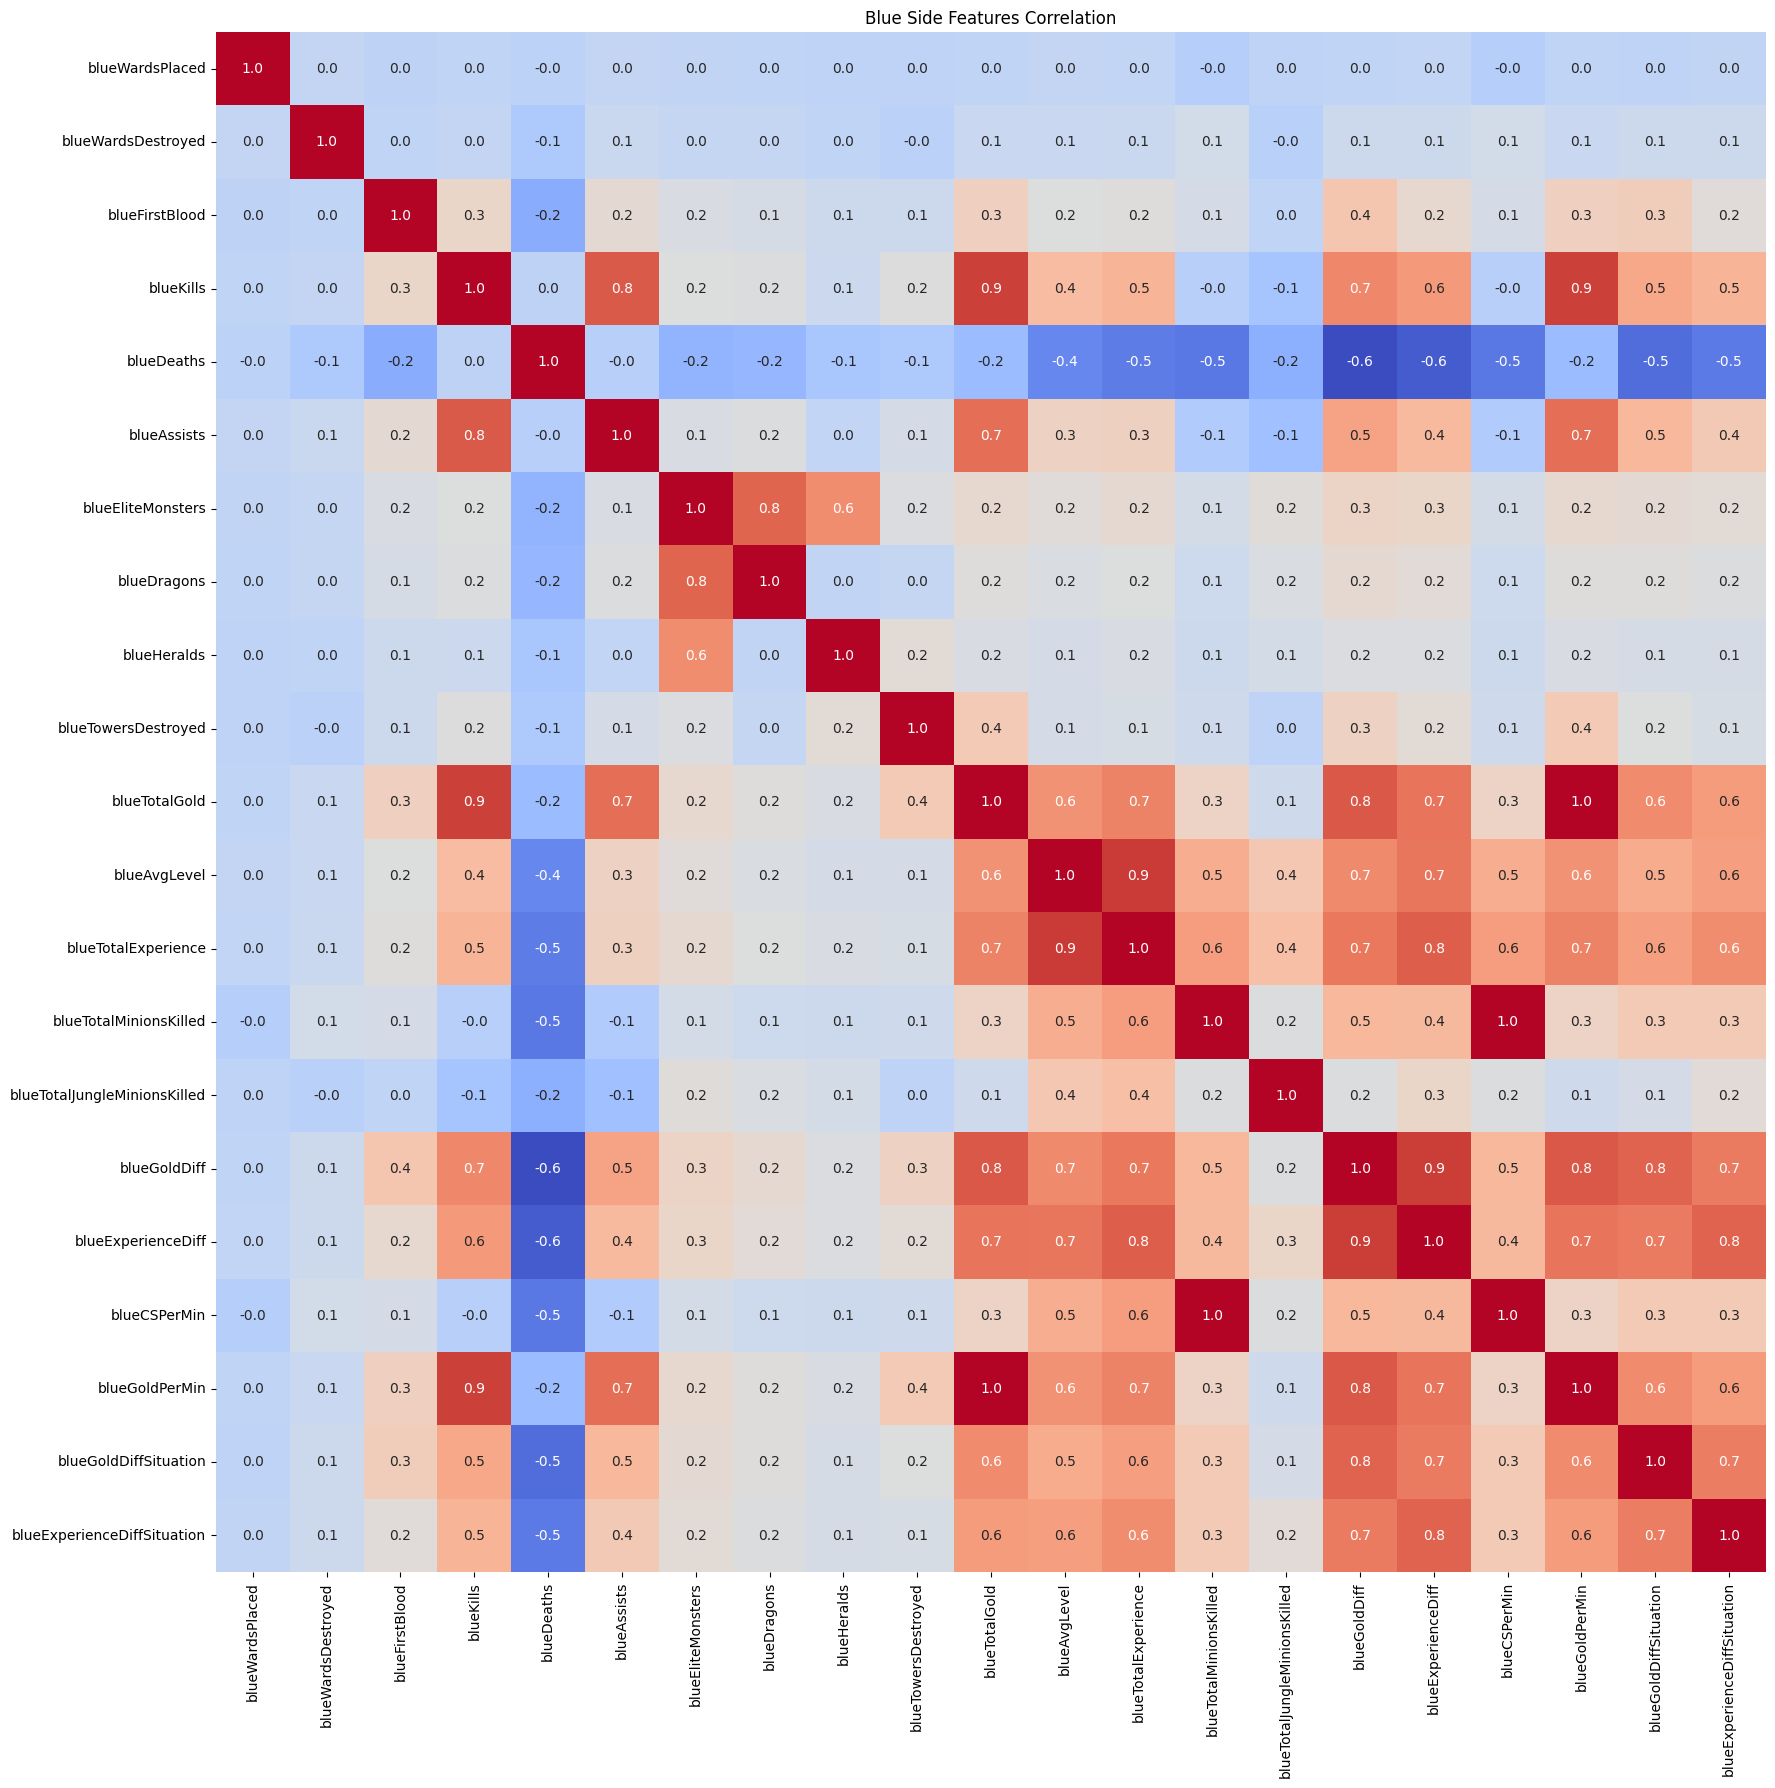

In [48]:
corr = df[[col for col in df.columns if 'blue' in col and col != 'blueWins']].corr()
f,ax = plt.subplots(figsize=(20, 20))
p = sns.heatmap(corr,
                cmap='coolwarm',
                annot=True,
                fmt=".1f",
                annot_kws={'size':10},
                cbar=False,
                ax=ax)
p.set_title('Blue Side Features Correlation')

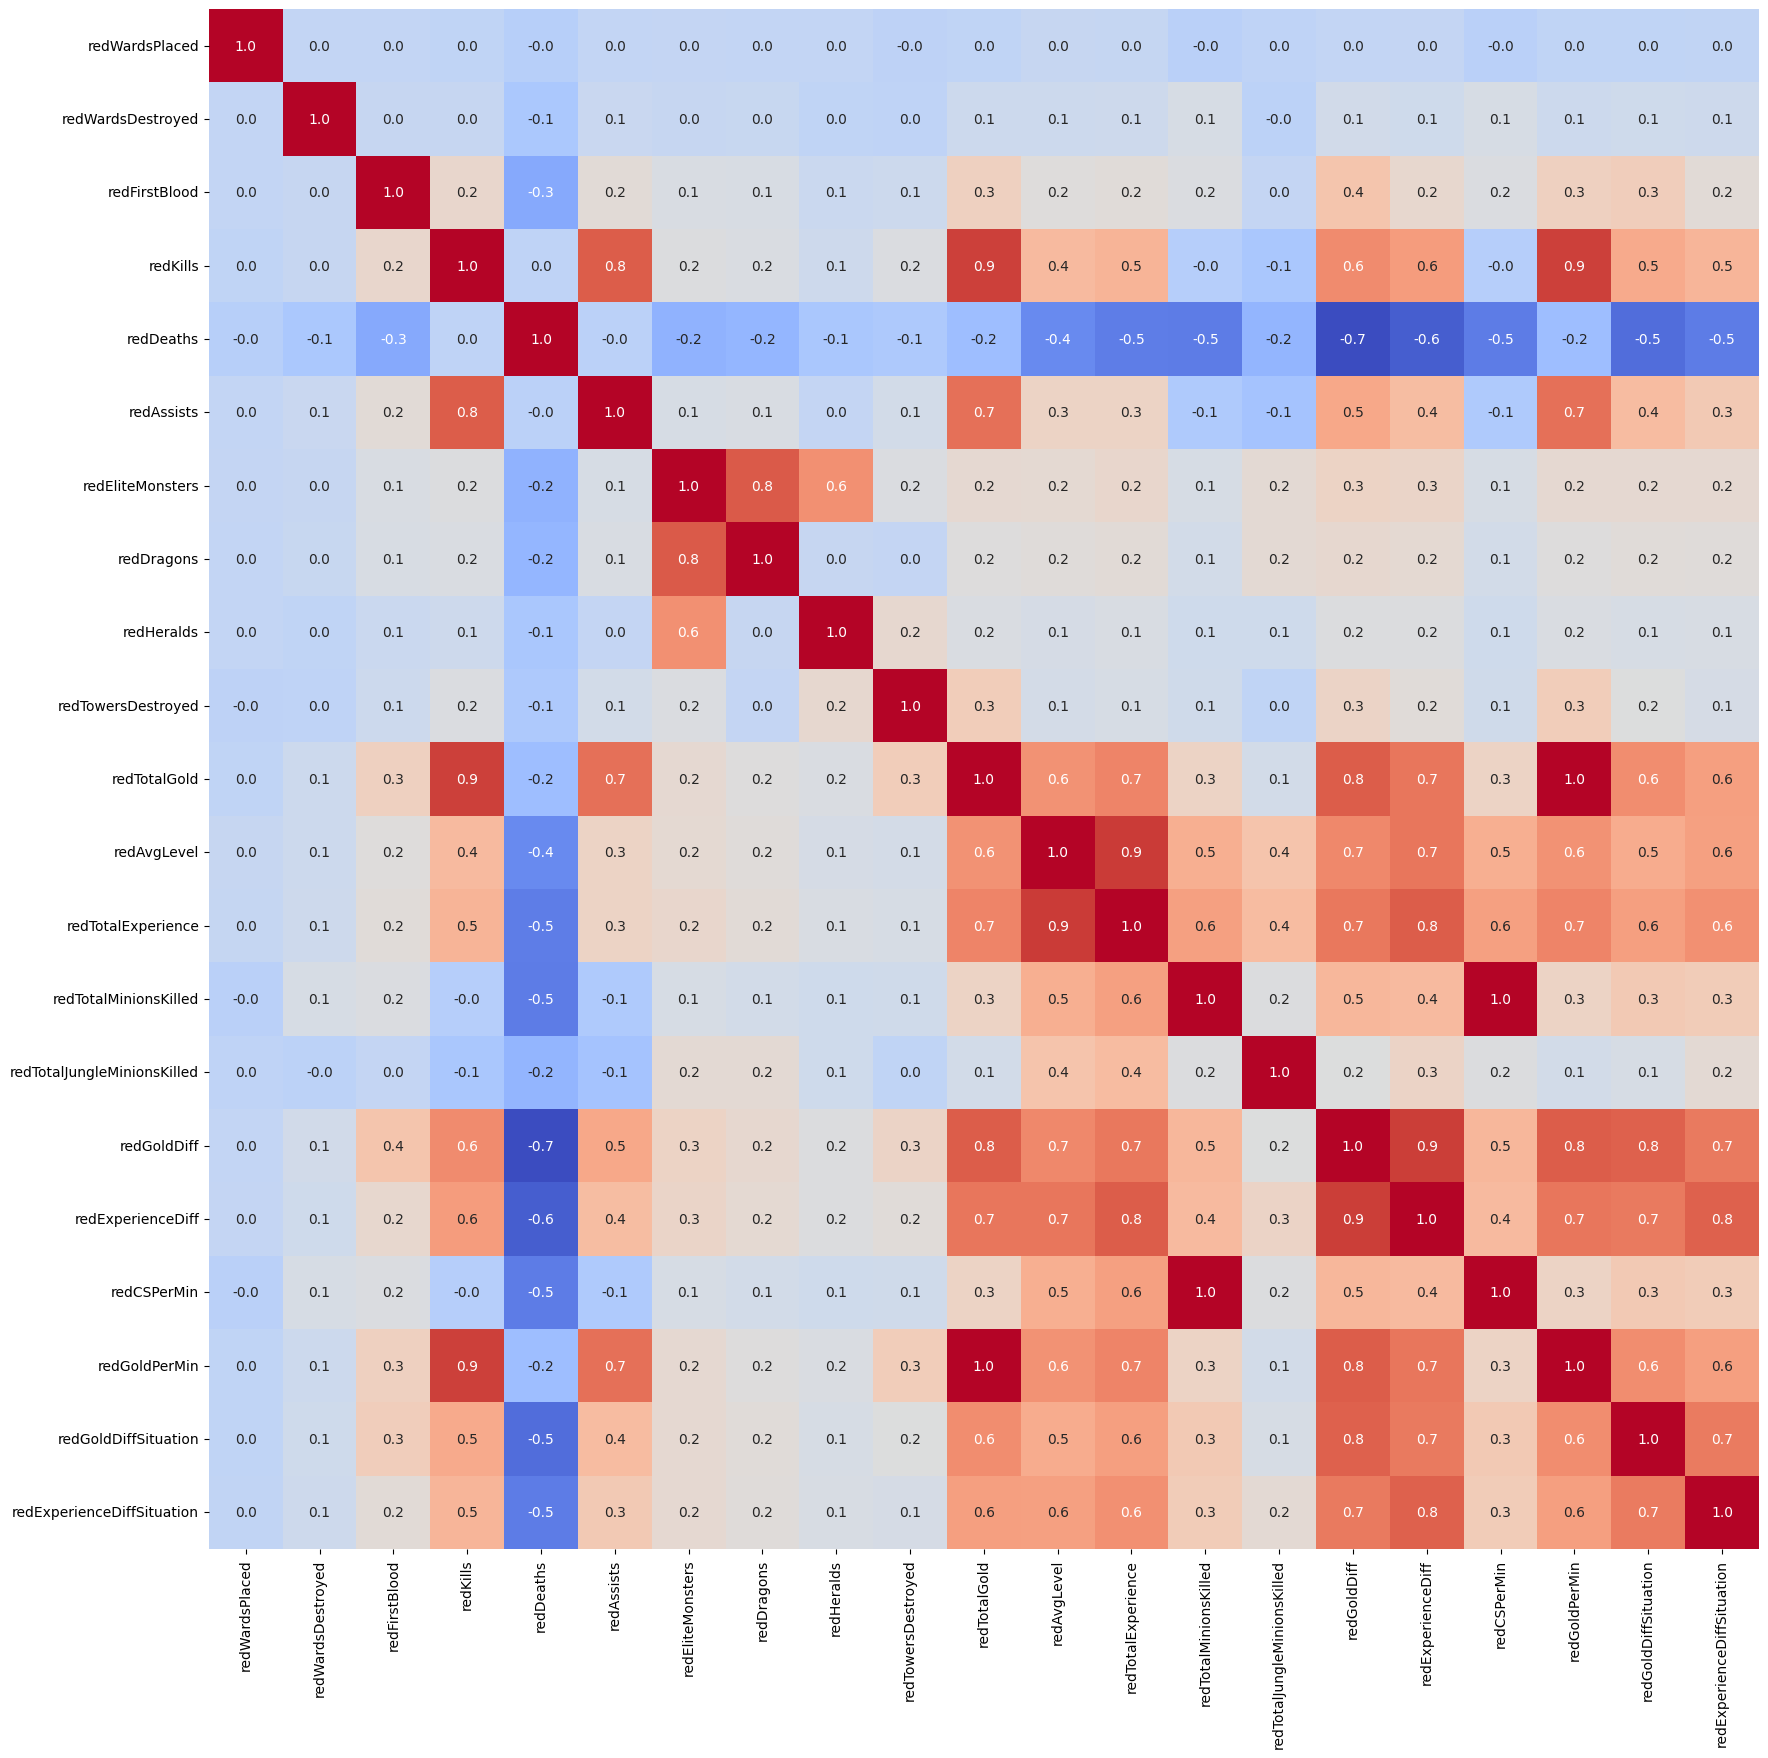

In [49]:
corr = df[[col for col in df.columns if 'red' in col and col != 'blueWins']].corr()
f,ax = plt.subplots(figsize=(20, 20))
p = sns.heatmap(corr,
                cmap='coolwarm',
                annot=True,
                fmt=".1f",
                annot_kws={'size':10},
                cbar=False,
                ax=ax)

從以上的關係圖表來看可以看到一些特徵之間的關係，例如：
- 金錢跟經驗有高度的正相關，與擊殺敵人數、助攻數也有高度的正相關
- 死亡則與經驗、金錢有負相關
- 菁英怪物數想然而與飛龍、諭示者有高度的正相關

這些數據連帶的關係都是環環相扣的，這些數據也都是影響遊戲結果的重要因素之一。

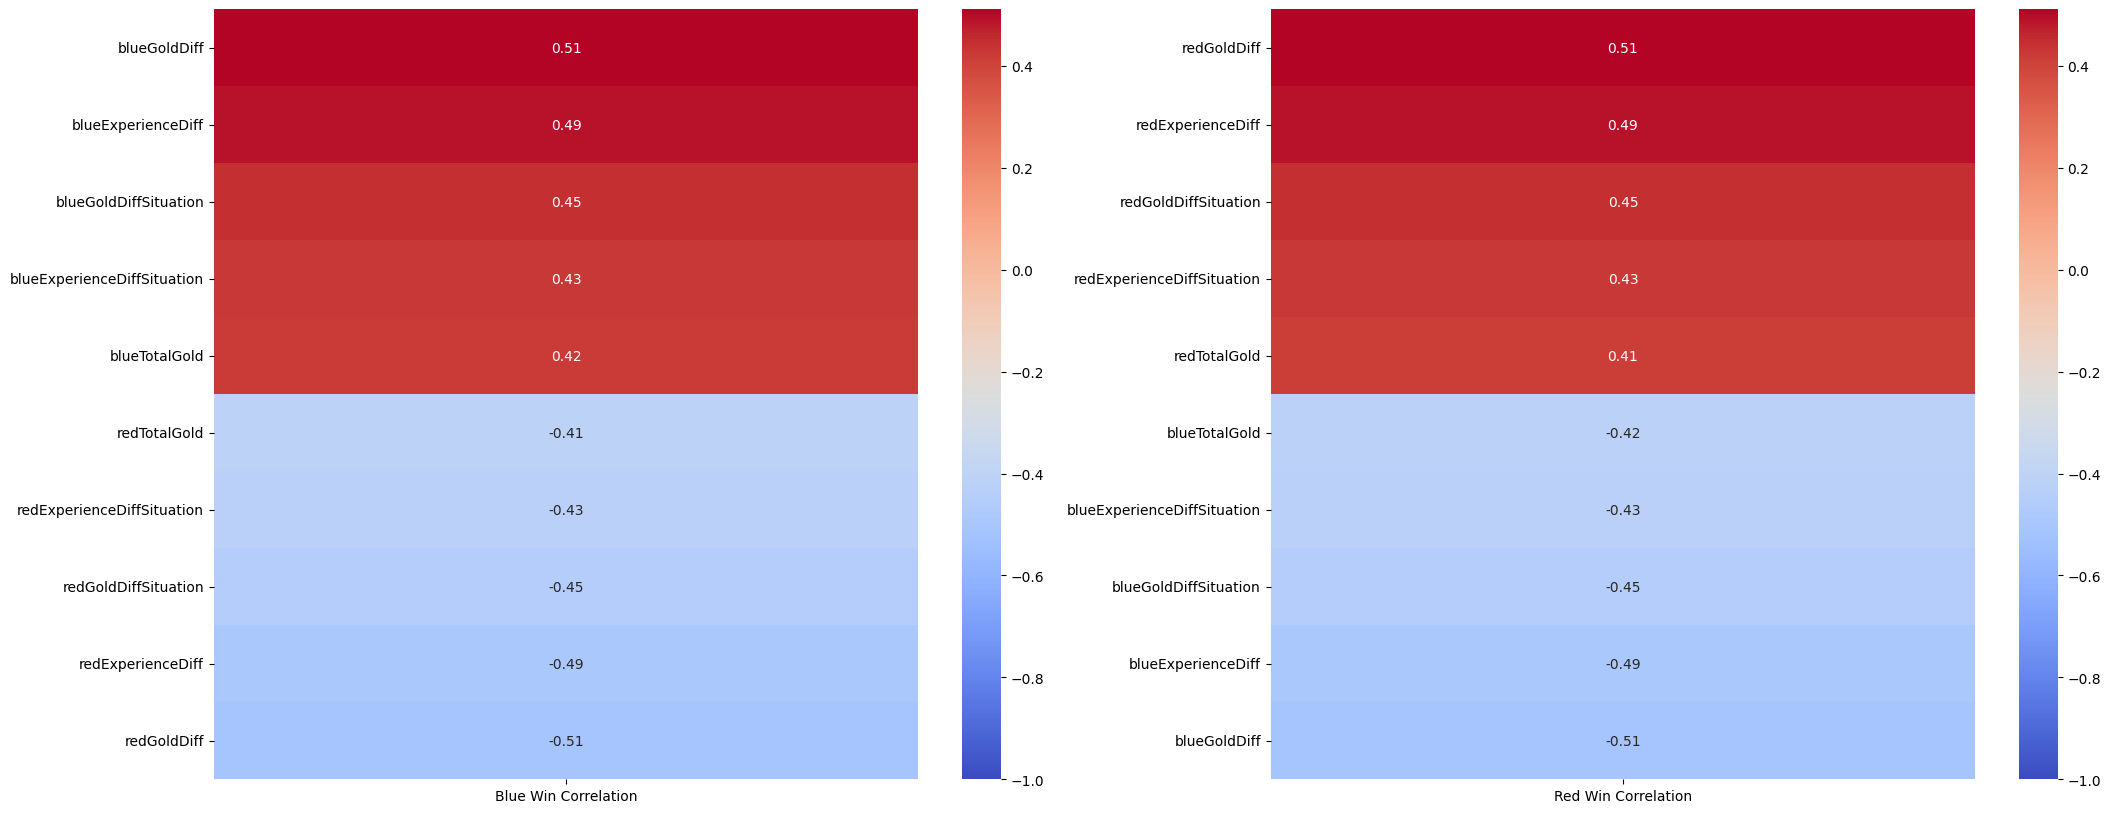

<Figure size 600x600 with 0 Axes>

In [51]:
# 先暫時轉回來
df['blueWins'] = df['blueWins'].map({'Blue Side': 1, 'Red Side': 0})

blue_win = df[[col for col in df.columns if col != 'blueWins']].corrwith(df['blueWins']).to_frame().sort_values(by = 0, ascending = False)
# 選取相關性最高的前5個和最低的後5個特徵
blue_win = pd.concat([blue_win.head(5), blue_win.tail(5)])
blue_win.columns = ['Blue Win Correlation']
blue_win

red_win = df[[col for col in df.columns if col != 'blueWins']].corrwith(df['blueWins'].map({0:1, 1:0})).to_frame().sort_values(by = 0, ascending = False)
red_win = pd.concat([red_win.head(5), red_win.tail(5)])
red_win.columns = ['Red Win Correlation']
red_win
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.figure(figsize=(6,6))

sns.heatmap(blue_win,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
           ax = ax1)

sns.heatmap(red_win,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
           ax = ax2)

從最後這兩張圖表來看可以知道說，若是想要贏下遊戲，金錢與經驗是最重要的因素之一，而且這兩個因素對於藍方與紅方的影響是相同的。

## 模型建立

接下來也會使用多種模型來測試哪種的效果最好

In [53]:
# 資料集分割
X = df.drop(['blueWins', 'gameId'], axis=1)
y= df["blueWins"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=3)

In [54]:
# 使用多種不同模型來做測試
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                        ('lr_classifier',LinearRegression())])

pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                        ('dt_classifier',DecisionTreeRegressor())])

pipeline_rf=Pipeline([('scalar3',StandardScaler()),
                        ('rf_classifier',RandomForestRegressor())])

pipeline_xgb=Pipeline([('scalar4',StandardScaler()),
                        ('xgb_classifier',XGBRegressor())])

pipeline_knn=Pipeline([('scalar5',StandardScaler()),
                        ('knn_classifier',KNeighborsRegressor())])

pipeline_lgbm=Pipeline([('scalar6',StandardScaler()),
                        ('lgbm_classifier',LGBMRegressor())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_xgb, pipeline_knn, pipeline_lgbm]

pipe_dict = {0: "Linear Regression", 1: "Decision Tree", 2: "Random Forest", 3: "XGBoost", 4: "KNN", 5: "LGBM"}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [55]:
cv_results = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, cv=10)
    cv_results.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

Linear Regression: -177513680163819104.000000 
Decision Tree: -0.469585 
Random Forest: 0.254478 
XGBoost: 0.159906 
KNN: 0.151195 
LGBM: 0.254707 


從結果來看，LGBMRegressor的表現最好，因此選擇LGBMRegressor作為最終模型，接下來還會再進行調參。

In [65]:
# 先測一下 LGBMRegressor 的測試結果
pred = pipeline_lgbm.predict(X_test)
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
# 計算準確率
# 將預測結果轉換成 0 或 1
pred = np.where(pred > 0.5, 1, 0)
accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

R^2: 0.2414659199907644
Adjusted R^2: 0.22833924864326216
MAE: 0.35934925002064494
MSE: 0.1895837874002333
RMSE: 0.4354122040092966
Accuracy: 70.89%


### Finetune一下模型
- GridSearchCV
- BayesianOptimization

In [67]:
# 設定 LGBM 的參數網格
param_grid = {
    'num_leaves': [31, 61],         # 決策樹葉子節點數量
    'learning_rate': [0.01, 0.1],   # 學習率
    'n_estimators': [100, 200]      # 決策樹數量
}

# 進行網格搜索
lgbm = lgb.LGBMClassifier()
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("最佳參數: ", grid_search.best_params_)
print("最佳交叉驗證得分: ", grid_search.best_score_)

最佳參數:  {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}
最佳交叉驗證得分:  0.7283026954079586


In [70]:
# 使用最佳參數重新訓練模型
lgbm = lgb.LGBMClassifier(**grid_search.best_params_)
lgbm.fit(X_train, y_train)

# 預測
pred = lgbm.predict(X_test)
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
# 計算準確率
# 將預測結果轉換成 0 或 1
pred = np.where(pred > 0.5, 1, 0)
accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

R^2: -0.11122259931467493
Adjusted R^2: -0.1304526566575741
MAE: 0.2777327935222672
MSE: 0.2777327935222672
RMSE: 0.5270035991549462
Accuracy: 72.23%


In [72]:
# 定義評估函數
def lgb_eval(num_leaves, learning_rate, n_estimators):
    params = {
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'objective': 'binary'
    }
    model = lgb.LGBMClassifier(**params)
    cv_result = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy').mean()
    return cv_result

# 定義參數空間 故意跟 GridSearchCV 的參數空間一樣測試一下效果
param_bounds = {
    'num_leaves': (31, 61),
    'learning_rate': (0.01, 0.1),
    'n_estimators': (100, 200)
}

# 創建貝葉斯優化對象
optimizer = BayesianOptimization(f=lgb_eval, pbounds=param_bounds, random_state=42)

# 執行優化
optimizer.maximize(init_points=5, n_iter=25)

# 輸出最佳參數和得分
print("最佳參數: ", optimizer.max['params'])
print("最佳交叉驗證得分: ", optimizer.max['target'])

|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | 0.7217    | 0.04371   | 195.1     | 52.96     |
| 2         | 0.7271    | 0.06388   | 115.6     | 35.68     |
| 3         | 0.7238    | 0.01523   | 186.6     | 49.03     |
| 4         | 0.7194    | 0.07373   | 102.1     | 60.1      |
| 5         | 0.7213    | 0.08492   | 121.2     | 36.45     |
| 6         | 0.7251    | 0.02141   | 186.7     | 48.81     |
| 7         | 0.7283    | 0.01694   | 115.6     | 36.23     |
| 8         | 0.7276    | 0.03953   | 114.7     | 36.46     |
| 9         | 0.7191    | 0.06926   | 115.6     | 37.78     |
| 10        | 0.7284    | 0.03797   | 114.5     | 35.63     |
| 11        | 0.7211    | 0.07896   | 113.2     | 35.23     |
| 12        | 0.7195    | 0.04647   | 187.0     | 47.22     |
| 13        | 0.7286    | 0.03695   | 114.7     | 34.83     |
| 14        | 0.7287    | 0.0385    | 115.0     | 33.83     |
| 15    

In [76]:
params = optimizer.max['params']
params['num_leaves'] = int(params['num_leaves'])
params['n_estimators'] = int(params['n_estimators'])
params['objective'] = 'binary'

# 使用最佳參數重新訓練模型
lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(X_train, y_train)
# 預測
pred = lgbm.predict(X_test)
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
# 計算準確率
# 將預測結果轉換成 0 或 1
pred = np.where(pred > 0.5, 1, 0)
accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

R^2: -0.12904103749610552
Adjusted R^2: -0.14857944852817662
MAE: 0.28218623481781374
MSE: 0.28218623481781374
RMSE: 0.5312120431784408
Accuracy: 71.78%


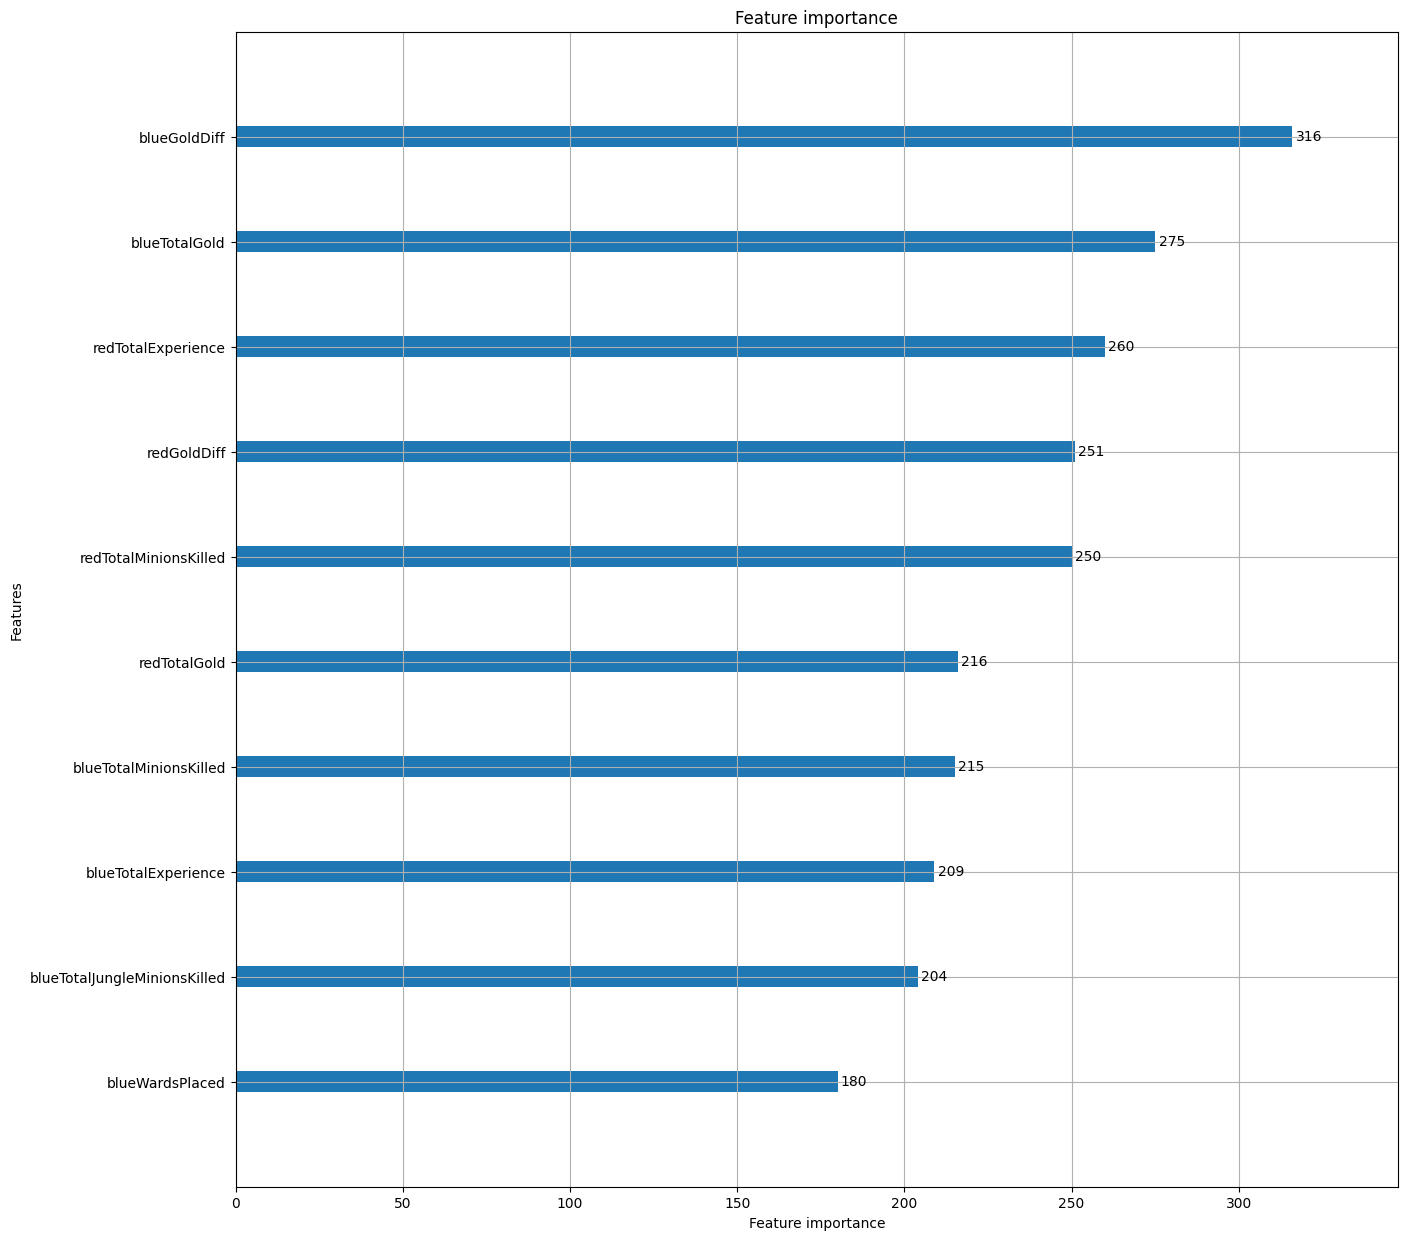

In [78]:
ax = lgb.plot_importance(lgbm, max_num_features=10, figsize = (15,15))
plt.show()

在這兩個優化方法中，貝葉斯優化的效果比 GridSearchCV 好，因為貝葉斯優化可以更好地探索參數空間，並找到最佳參數。

但實際上訓練時需要針對參數取整，因為 LGBMClassifier 的 num_leaves 和 n_estimators 參數必須是整數，所以在訓練時需要將這兩個參數轉換為整數。

以最終結果來看，還是GridSearchCV的效果比較好，但是貝葉斯優化的效果也不錯，並且可以更好地探索參數空間，找到最佳參數。

已從模型的特徵重要性圖表中可以看出，blueGoldDiff、blueExperienceDiff、blueGoldPerMin、blueKills、blueTotalGold 是影響獲勝的最重要特徵。


## Conclusion
總結上面所有的分析，我們可以得到以下結論：
- 獲得金錢和經驗優勢是獲勝的重要因素之一，大致上就會奠定70%的勝利機率，而金錢和經驗也跟 KDA 有很大的關聯
- 獲得第一血的一方，勝率會高於對方，大致會有60%的勝率
- 獲得第一條飛龍的一方，勝率會高於對方，大致會有60%的勝率，但是獲得第一條諭示者的一方，勝率卻只有50~52%左右，因此飛龍的重要性遠大於峽谷先鋒
- 在藍方時，獲得第一條飛龍的勝率高於紅方，所以有機會的話勢必要爭奪一下飛龍，能給予團隊較大的優勢

所以，如果要獲勝，就要在遊戲中多多注意這些關鍵因素，才能提高勝率!!!。
